# 1) The Problem

We have set out to build a Recurrent Neural Network to predict if a question is true or false based on a small passage regarding the topic.

# Preformance Metrics

Their baseline was 80.4% after the creation of a new algorithm. There was a 90% accuracy when humans labeled the questions with their respective true or false answers. The majority-baseline was 62%. This means that instead of having a 50/50 split on their data, they had a 62/38 split. 

# Why is this important?

With more and more companies moving to an automated chat bot style of customer service, the accuracy with which a computer can answer questions is paramount.

#  2) Collection/Discussion of Data

Our data came from https://github.com/google-research-datasets/boolean-questions. All of the questions are true or false. This data set was used in a research paper from Google employees published in 2019.

# 3) Data Analysis

# Code

In [3]:
#Imports for path models and nlp pipeline.
import os
import random
import re
import jsonlines
import numpy as np
import pickle
import tensorflow as tf
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack,vstack
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Concatenate, Dense, Dropout, LSTM, Bidirectional
from tensorflow.keras.activations import relu
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, plot_confusion_matrix
import itertools
import matplotlib.pyplot as plt

In [4]:
#Pulls random indecies to print.
def getRandomIndecies(desired_range, n_indecies=5):
    randoms = list()
    for x in range(n_indecies):
        randoms.append(random.randint(0,desired_range))
    return randoms

Path for text.

In [5]:
qa_path = os.path.join(os.getcwd(),"question_answer")

Pulls all text from files into an array of questions, titles, answers, and passages.

In [6]:
qa_array = list()

qa_file = open(os.path.join(qa_path,"train.jsonl"), encoding="utf-8")
for line in qa_file.readlines():
    qa_array.append(line)
qa_file.close()

qa_file = open(os.path.join(qa_path,"test.jsonl"), encoding="utf-8")
for line in qa_file.readlines():
    qa_array.append(line)
qa_file.close()

Prints datapoint to see amount of data and analyze the text.

In [7]:
print("Datapoints:",len(qa_array),'\n')
for index in getRandomIndecies(len(qa_array)):
    print(qa_array[index],'\n')

Datapoints: 12697 

{"question": "have we ever been to the bottom of the marianas trench", "title": "Mariana Trench", "answer": "true", "passage": "Four descents have been achieved. The first was the manned descent by Swiss-designed, Italian-built, United States Navy-owned bathyscaphe Trieste which reached the bottom at 1:06 pm on 23 January 1960, with Don Walsh and Jacques Piccard on board. Iron shot was used for ballast, with gasoline for buoyancy. The onboard systems indicated a depth of 11,521 m (37,799 ft), but this was later revised to 10,916 m (35,814 ft). The depth was estimated from a conversion of pressure measured and calculations based on the water density from sea surface to seabed."}
 

{"question": "did the tomb raider game come out before the movie", "title": "Tomb Raider", "answer": "true", "passage": "Tomb Raider, also known as Lara Croft: Tomb Raider between 2001 and 2007, is a media franchise that originated with an action-adventure video game series created by Brit

# 4A) Preprocessing

## Sequence

Title is redudant so we only extract the question, answer and passage. 
Extracts question, passage, and answer from the text.

In [8]:

qap_array = list()

for qa in qa_array:
    sections = re.findall(r'"([^"]*)"', qa)
    qap = ()
    for x,section in enumerate(sections):
        if(section == "question" or section == "answer" or section == "passage"):
            qap = qap + (sections[x+1].lower(),)
    qap_array.append(qap)

Prints the seperated question, answer and passage.

In [9]:
print("QAP's:",len(qap_array),'\n')
for index in getRandomIndecies(len(qap_array)):
    print(qap_array[index],'\n')

QAP's: 12697 

('is there an in n out in canada', 'false', "in-n-out burger is an american regional chain of fast food restaurants with locations primarily in the american southwest and pacific coast. it was founded in baldwin park, california in 1948 by harry snyder and esther snyder. the chain is currently headquartered in irvine, california and has slowly expanded outside southern california into the rest of california, as well as into arizona, nevada, utah, texas, oregon,and alabama. the current owner is lynsi snyder, the snyders' only grandchild.") 

('does the fender hot rod deluxe have an effects loop', 'true', "as an all-tube (pre-amp and power sections) combo guitar amplifier, the hot rod deluxe features a pair of 6l6gc beam tetrodes for the power section and two 12ax7 dual triodes for the preamp section. one additional 12ax7 tube is utilized for the phase inverter of the power section. however, the rectifier, reverb driver and recovery, and effects loop circuits are solid sta

Creates a pickle object file of the qap's.

In [10]:
try:
    qap_location = os.mkdir(os.path.join(os.getcwd(),"Preprocessed_Text"))
except OSError:
    None

qap_location = os.path.join(os.getcwd(), "Preprocessed_text", "preprocessed_text")    

file = open(qap_location, "wb")
    
pickle.dump(qap_array,file)

file.close()

Loads in the pickle object and splits the sections into questions, answers, passage.

In [11]:
questions = list()
answers = list()
passages = list()

file = open(qap_location, "rb")

for item in pickle.load(file):
    questions.append(item[0])
    answers.append(item[1])
    passages.append(item[2])

Ratio of true/false.

In [12]:
counter = 0
for item in answers:
    if(item == 'true'):
        counter += 1

print((counter/len(qa_array))*100)

62.27455304402615


Print seperate questions, answers, and passages.

In [13]:
indecies = getRandomIndecies(len(qap_array))

Question

In [14]:
for index in indecies:
    print(questions[index],'\n')

is the state of the union address mandated by the constitution 

was employee of the month filmed at costco 

can a flare gun be used as a weapon 

has an australian ever won the tour de france 

is insulation tape the same as electrical tape 



Answer

In [15]:
for index in indecies:
    print(answers[index],'\n')

true 

true 

true 

true 

true 



Passage

In [16]:
for index in indecies:
    print(passages[index],'\n')

the address fulfills rules in article ii, section 3 of the u.s. constitution, requiring the president to periodically ``give to the congress information of the state of the union, and recommend to their consideration such measures as he shall judge necessary and expedient.'' during most of the country's first century, the president primarily only submitted a written report to congress. after 1913, woodrow wilson, the 28th u.s. president, began the regular practice of delivering the address to congress in person as a way to rally support for his agenda. with the advent of radio and television, the address is now broadcast live across the country on many networks. 

employee of the month is a 2006 american comedy film directed by greg coolidge, written by don calame, chris conroy, and coolidge, and starring dane cook, jessica simpson and dax shepard. the main plot revolves around two shop employees (portrayed by cook and shepard) who compete for the affection of their newest co-worker. t

## Tokenize

Splits questions and passages into word tokens on the space.

In [17]:
def tokenize(lst):
    tokenized_list = list()
    
    for item in lst:
        sequence = list()
        temp = item.split()
        for token in temp:
            sequence.append(token)
        tokenized_list.append(sequence)
        
    return tokenized_list

In [18]:
qtokenized = tokenize(questions)
ptokenized = tokenize(passages)
print("Question\n", qtokenized[0])
print("Passage\n", ptokenized[0])

Question
 ['do', 'iran', 'and', 'afghanistan', 'speak', 'the', 'same', 'language']
Passage
 ['persian', '(/ˈpɜːrʒən,', '-ʃən/),', 'also', 'known', 'by', 'its', 'endonym', 'farsi', '(فارسی', 'fārsi', '(fɒːɾˈsiː)', '(', 'listen)),', 'is', 'one', 'of', 'the', 'western', 'iranian', 'languages', 'within', 'the', 'indo-iranian', 'branch', 'of', 'the', 'indo-european', 'language', 'family.', 'it', 'is', 'primarily', 'spoken', 'in', 'iran,', 'afghanistan', '(officially', 'known', 'as', 'dari', 'since', '1958),', 'and', 'tajikistan', '(officially', 'known', 'as', 'tajiki', 'since', 'the', 'soviet', 'era),', 'and', 'some', 'other', 'regions', 'which', 'historically', 'were', 'persianate', 'societies', 'and', 'considered', 'part', 'of', 'greater', 'iran.', 'it', 'is', 'written', 'in', 'the', 'persian', 'alphabet,', 'a', 'modified', 'variant', 'of', 'the', 'arabic', 'script,', 'which', 'itself', 'evolved', 'from', 'the', 'aramaic', 'alphabet.']


Verify lengths

In [19]:

print(len(qtokenized))
print(len(ptokenized))

12697
12697


Cleans tokens of punctuations and splits hyphenated words.

In [20]:
def cleanTokens(lst):
    
    punctuations = ['\'','!','(',')','[',']','{','}',';',':','"','\\',',','<','>','.','/','?','@','#','$','%','^','&','*','_','~','`']
    hyphen = ['-']
    clean_lst = list()
    for item in lst:
        tokens = list()
        for token in item:
            token_string = ""
            for char in token:
                if(char not in punctuations and char != '-'):
                    token_string = token_string + char
                elif(char in hyphen):
                    tokens.append(token_string)
                    token_string = ""
            tokens.append(token_string)
        clean_lst.append(tokens)
    
    return clean_lst

In [21]:
qtokenized_clean = cleanTokens(qtokenized)
ptokenized_clean = cleanTokens(ptokenized)
print("Question\n", qtokenized_clean[0])
print("Passage\n", ptokenized_clean[0])

Question
 ['do', 'iran', 'and', 'afghanistan', 'speak', 'the', 'same', 'language']
Passage
 ['persian', 'ˈpɜːrʒən', '', 'ʃən', 'also', 'known', 'by', 'its', 'endonym', 'farsi', 'فارسی', 'fārsi', 'fɒːɾˈsiː', '', 'listen', 'is', 'one', 'of', 'the', 'western', 'iranian', 'languages', 'within', 'the', 'indo', 'iranian', 'branch', 'of', 'the', 'indo', 'european', 'language', 'family', 'it', 'is', 'primarily', 'spoken', 'in', 'iran', 'afghanistan', 'officially', 'known', 'as', 'dari', 'since', '1958', 'and', 'tajikistan', 'officially', 'known', 'as', 'tajiki', 'since', 'the', 'soviet', 'era', 'and', 'some', 'other', 'regions', 'which', 'historically', 'were', 'persianate', 'societies', 'and', 'considered', 'part', 'of', 'greater', 'iran', 'it', 'is', 'written', 'in', 'the', 'persian', 'alphabet', 'a', 'modified', 'variant', 'of', 'the', 'arabic', 'script', 'which', 'itself', 'evolved', 'from', 'the', 'aramaic', 'alphabet']


Verify lengths

In [22]:
print(len(qtokenized_clean))
print(len(ptokenized_clean))

12697
12697


## Create Vocabulary

Creates a vocabulary from the words in the token list.

In [23]:
def getVocab(lst):
    
    vocab = dict()
    
    for text in lst:
        for token in text:
            if(vocab.get(token,"") == ""):
                vocab.update({token : 1})
            else:
                vocab[token] = vocab[token]+1
                
    return vocab

In [24]:
qvocab = getVocab(qtokenized_clean)
pvocab = getVocab(ptokenized_clean)
print("Words in questions vocab:",len(qvocab))
print("Words in passages vocab:",len(pvocab))

Words in questions vocab: 10507
Words in passages vocab: 50673


Retreives statistics from the vocab(average appearance, most common, least common). Prints all vocabulary and their appearances.

In [25]:
def vocabStats(vocab,whole_vocab=False):
    
    vocab_array = list()
    
    minimum = ("",1000000000)
    maximum = ("",0)
    avg = 0 
    stnd = 0 
    
    for word in vocab:
        if(whole_vocab == True):
            print(word, vocab[word])
        if(vocab[word] > maximum[1]):
            maximum = (word,vocab[word])
        if(vocab[word] < minimum[1]):
            minimum = (word,vocab[word])
        vocab_array.append(vocab[word])
        
    avg = np.mean(vocab_array)
    stnd = np.std(vocab_array)
    
    print("Min count:", minimum, "Max count:", maximum, "Average appearance:", avg, "Standard Deviation:", stnd)
    return vocab,avg,stnd

In [26]:
qvocab, qavg, qstnd = vocabStats(qvocab,True)

do 964
iran 1
and 1534
afghanistan 2
speak 9
the 8578
same 1742
language 49
good 36
samaritan 2
laws 17
protect 3
those 2
who 34
help 6
at 308
an 565
accident 2
is 5985
windows 10
movie 450
maker 1
part 518
of 3016
essentials 1
confectionary 1
sugar 19
as 1176
powdered 2
elder 3
scrolls 4
online 8
skyrim 3
can 1568
you 1211
use 128
oyster 4
card 66
epsom 2
station 46
will 272
there 1729
be 866
a 5921
season 609
4 129
da 3
vincis 1
demons 2
federal 44
court 97
supreme 60
did 605
abraham 1
lincoln 3
write 17
letter 16
in 3457
saving 4
private 20
ryan 5
batman 14
robin 7
sequel 131
to 1913
forever 8
wolverine 1
badger 1
green 47
lantern 4
2 262
does 1350
icc 2
has 451
jurisdiction 4
united 188
states 201
calcium 8
carbide 1
cac2 1
raw 8
material 5
for 527
production 5
acetylene 2
now 17
see 27
me 57
3 159
coming 34
out 168
penalty 36
shoot 21
goal 32
count 63
towards 8
golden 44
boot 12
new 325
cutthroat 3
kitchen 7
jack 26
sikma 1
hall 46
fame 46
elves 2
humans 11
mate 11
lord 25
rings 2

lice 11
guardian 5
lebanon 1
monaco 2
mission 4
tennis 9
china 20
fifa 35
semi 10
finals 23
beans 23
french 16
japan 10
zone 30
spiderman 3
homecoming 3
amazing 5
spider 17
entire 5
blastocyst 1
develop 3
fetus 1
someone 23
handed 7
phryne 1
fisher 3
wild 23
uno 10
hold 10
foreign 9
title 14
social 22
security 24
digits 1
grand 23
slam 4
itv 5
hub 4
trapezoid 4
prime 31
minister 23
mp 2
veteran 2
base 42
possession 3
21 14
2017 10
chevy 9
cruze 1
front 23
lake 46
puerto 49
follow 10
every 74
anything 17
faster 13
speed 32
light 47
mr 13
robot 5
element 11
types 8
atoms 5
cougar 8
lion 21
jimmy 2
o 14
sons 12
anarchy 11
triamcinolone 6
acetonide 5
cream 30
poison 10
ivy 22
rabbit 12
tinkerbell 4
cash 14
money 50
mart 3
ok 7
eat 24
cooking 4
apples 2
fly 34
height 11
american 82
ordinary 3
catholic 9
church 30
borderlands 2
handsome 3
collection 5
dlc 4
project 6
runway 1
junior 3
transit 11
aba 4
routing 10
hashtag 1
f 6
train 47
stop 30
queens 17
plaza 2
slugs 1
snails 1
quarter 6
affe

score 15
kickoff 3
around 12
stark 5
captain 20
matrix 6
economy 4
dolores 1
claiborne 1
awards 15
cast 26
bass 7
pro 12
shops 6
cabelas 1
warning 2
ticket 14
glee 5
sectionals 2
papillon 2
qatar 2
host 21
willie 1
robertson 1
duck 3
dynasty 3
passed 5
away 19
truth 6
lending 1
regulates 2
interest 6
rates 1
loans 3
together 65
strings 2
attached 3
blackbird 1
yellow 23
beak 1
traffic 8
control 6
switched 1
alternative 3
minimum 6
ryne 1
sandberg 1
six 12
making 31
seven 11
parables 1
gospel 2
cyst 2
m 3
junction 2
mary 17
witch 6
witchs 1
flower 8
ipv6 1
unique 3
local 4
unicast 1
addresses 2
routable 1
within 4
outside 19
organization 14
angels 7
cognitive 2
therapy 4
behavioural 1
receive 4
communion 2
episcopal 3
originals 12
ned 1
hunger 5
words 17
pan 4
am 34
chicago 27
petes 2
happy 5
lobster 9
olive 4
trial 6
hypochondriac 1
mental 1
illness 2
riddler 1
olfactory 1
epithelium 1
mucous 1
membrane 12
covering 1
inferior 2
nasal 1
conchae 1
optic 3
central 24
nervous 14
maurice 1


ncaa 9
tournament 3
tigers 6
bengal 2
2010 2
blur 2
gorillaz 2
metal 8
vulcanisation 1
rubber 2
declare 6
scott 6
sid 1
bourbon 5
spell 1
dyslexia 2
swift 5
bsb 2
hydro 1
sse 1
certified 3
abstract 1
leeds 1
ao 1
exorcist 2
iso 1
manny 1
senior 2
varsity 3
t 15
mobile 11
shooting 15
fashion 6
oats 4
rolled 1
dial 1
colorado 19
december 1
molecules 3
contain 5
sets 6
but 5
properties 3
wayne 7
rooney 1
dalyan 1
pentagon 2
iwatobi 1
swim 4
agricultural 2
adjustment 1
farmers 2
subsidies 2
kane 1
well 1
although 1
praised 1
critics 1
sloan 5
chuck 3
gossip 9
sam 11
quantum 8
leap 2
allow 5
smoking 4
carnival 4
tourist 3
taiwan 6
panda 9
bee 19
stings 3
opening 5
huntsman 1
google 16
duo 2
encryption 1
grip 2
shotguns 1
fifth 8
worlds 5
fair 8
samsung 1
galaxy 15
fingerprint 1
scanner 1
lucky 5
chinese 11
culture 3
pc 4
jesuits 1
pope 1
what 25
furries 1
pull 3
emergency 4
vehicles 1
ask 2
cashback 1
maude 1
poisoning 3
included 7
edition 6
att 1
diners 2
ins 1
dives 1
38 8
sw 2
pocket 3
d

xp 1
signs 2
undefeated 4
archie 5
wrought 1
sand 3
pebbles 1
et 3
eagles 3
werewolf 3
spectre 1
craig 2
calls 7
increase 5
shifts 1
tara 6
keith 2
climax 1
2019 1
started 5
grade 9
commission 3
vineyards 1
retroverted 1
anteverted 1
nightmare 3
lights 16
warn 6
belfast 1
george 19
tangled 1
racquetball 1
bicarbonate 2
carlin 1
teds 2
excellent 1
adventure 9
hybrid 3
hearts 6
mouth 12
gastrointestinal 3
tract 9
taken 5
monoxide 2
detectors 1
enter 11
labor 4
relations 4
aluminum 2
pots 2
cooktops 4
l 3
24 11
angles 15
add 6
180 6
als 2
lou 2
gehrigs 1
midnight 2
studies 7
xmen 2
fleetwood 2
mac 13
versailles 5
youre 1
reunion 1
darkest 2
amtrak 2
flint 2
mi 1
orions 3
ellen 4
waltons 3
constructor 1
class 7
c++ 2
bronx 2
corp 2
spinners 1
directions 3
nationals 2
feel 6
medals 4
apocrypha 1
ackley 2
waterloo 4
capitals 13
railroad 4
underground 2
dwarf 4
deion 2
sanders 2
hardball 1
cops 2
milky 4
belong 3
cluster 2
spouse 3
testify 2
gate 5
cursed 5
magicians 2
gear 6
pain 8
younger 1

pitcher 10
wisk 1
laundry 1
detergent 2
vowel 4
fortune 4
covered 3
contracts 4
chromatography 2
meet 10
nurse 4
inn 2
cemetary 1
halide 1
bacteriophages 1
diseases 2
jordans 2
losing 4
egg 9
horror 6
initial 2
tartaric 1
0 15
julius 1
protector 1
suppressor 1
wellness 1
ally 4
ww2 9
ladies 2
yale 2
lacrosse 2
rotten 5
flamethrower 1
defend 1
cytoskeleton 1
rumpelstiltskin 1
managers 1
jaywalk 2
dying 4
following 3
meanders 1
garage 1
arc 3
fault 8
madeira 2
sponge 1
talent 9
32 2
auto 5
acp 4
nhl 19
furious 8
edge 3
27th 1
definitive 1
butt 2
usernames 1
passwords 1
displayed 1
clear 1
default 1
hanger 2
skirt 1
luther 1
gliders 1
allspice 2
berries 3
yes 4
nordstrom 2
rack 2
bitterroot 1
rockies 5
donald 1
pure 4
genius 2
edf 1
dynamic 1
priority 1
scheduling 1
algorithm 1
didnt 4
jo 2
nintendo 4
ds 8
lite 4
basilica 1
vatican 3
exercise 1
asthma 1
saratoga 1
1777 1
took 1
grain 1
wholemeal 4
cn 3
reacher 3
appendix 1
immune 5
ex 5
iconic 1
precious 1
gemstone 1
colombia 5
emerald 1


blanchett 1
jasmine 1
matters 1
gateway 2
router 1
elephants 2
firearm 4
synthesize 1
lipids 2
carbohydrates 1
proteins 2
esophagus 3
digestive 4
korra 3
shape 8
volume 3
bigg 1
tamil 1
bahrain 1
ccr 2
potato 5
toy 4
computer 5
brooks 4
robinson 2
dpt 1
undead 1
perform 5
reactions 2
availability 1
reactants 2
loko 1
carter 3
except 1
for​ 1
opossums 1
marsupials 1
hathaway 1
anglia 1
dundee 1
tap 2
fiber 4
fmla 1
bladder 3
transplant 2
months 3
plug 5
tesla 1
preside 1
supper 3
painted 2
drivers 15
tonne 1
malar 1
rash 3
lupus 2
reasonable 1
impose 1
rent 4
payment 1
excess 1
pillars 3
eternity 2
remastered 1
masonic 1
shake 2
shotgunning 1
austin 1
conrad 2
dobler 1
colon 4
cabin 3
forza 1
stealing 2
interview 1
tramell 1
instinct 1
amygdala 2
autonomic 3
secondary 5
education 10
checking 1
account 9
transfers 1
usc 1
picking 2
nose 3
candle 2
candlelight 1
vigil 1
goat 2
nolan 1
chart 2
copy 3
dragons 3
den 2
octave 1
knoxville 1
freepost 3
gandalf 2
p 5
51 2
farrells 1
parlor 1
app

describes 1
westminster 2
abbey 3
cartier 1
bracelet 1
airline 1
thc 2
charlottes 2
cbd 2
aortic 3
stenosis 1
slay 1
spire 1
salto 1
ángel 1
deliverance 1
deployed 1
warrantless 1
searches 2
seizures 2
lawful 2
subject 3
mid 4
provider 1
shaw 1
diplomas 1
recognised 1
lark 1
candleford 1
ming 1
emperors 1
divided 2
join 5
frappe 1
gemma 2
midlands 1
pickles 2
burgers 5
soy 4
soybean 1
easy 1
accurate 3
uber 2
eats 1
spotted 1
parasite 1
76ers 1
battlefield 3
aw 1
people 1
believe 2
pentatonic 1
absorb 2
flank 1
yorker 1
fixation 1
ops 8
zombies 3
bieber 1
deed 5
kyrie 1
irving 1
lyrics 3
duel 2
fates 1
thyroid 2
ʺfruits 1
treeʺ 1
doctrine 1
applies 1
arrests 1
snl 1
trigger 1
malignant 1
hyperthermia 1
hobs 1
homers 1
couple 2
flipping 1
differentiable 1
jessie 1
wat 1
jerusalem 1
leprosy 1
tacoma 2
goghs 1
starry 1
impressionist 1
endorsed 1
republican 3
ape 2
loose 1
orcas 1
boost 2
sociology 1
psychology 3
wasp 4
burnham 3
acadia 1
spare 2
seek 3
asylum 4
drum 1
wishes 1
candles 1
b

kung 3
fu 3
awesomeness 1
prisons 2
parsons 1
directed 1
motorcycles 3
lanes 3
scoring 1
cooprative 1
borrowers 1
malcolm 2
tectonic 1
blarney 2
frasier 3
eli 7
allied 4
delphi 1
consensus 1
among 1
experts 1
jurrassic 1
mitosis 2
nipples 1
blackhawks 2
airlink 1
dorsal 2
fin 1
coaches 1
suny 2
mandated 1
hugh 1
antarctic 1
fs1 1
rap 1
door 5
portland 1
jealousy 1
sparrow 2
claire 1
views 1
magus 1
tables 1
maps 1
tertiary 1
breeds 2
gestation 1
periods 2
men 2
unto 2
others 1
lee 1
curtis 2
h20 1
reign 1
engraved 1
spartacus 2
ori 1
ankle 1
cosmic 1
tesseract 1
miyagi 1
karate 3
soap 3
carmel 2
colors 5
pigment 1
cyan 1
sidney 1
poitier 1
told 1
holders 1
nepal 2
andersen 1
beachline 1
expressway 1
intercept 1
mandalay 1
bhartiya 1
mahila 1
sector 2
bump 1
bennie 2
monsters 2
historian 1
22 8
wmr 3
chrysanthemum 1
mum 2
wrath 4
weak 1
sway 2
stabilizer 2
cervix 2
eyeliner 1
hex 2
wrench 1
navient 2
matt 1
potatoes 2
minors 5
eleanor 1
royals 1
vernal 1
cuttlefish 1
substances 1
mixtur

konigsberg 1
torchwood 1
numbered 1
parton 1
lived 2
accessed 1
mangoes 1
peaches 1
isbn 1
creatinine 1
gfr 1
isles 4
scilly 1
leviticus 1
lynette 1
spoiler 1
mustache 1
crunchyroll 2
faulk 1
marshals 2
fugitive 2
inspection 1
rbs 1
2033 1
improvements 1
agriculture 1
industrialisation 1
ultraviolet 1
lansbury 1
molinari 1
sicily 1
outliers 1
brake 3
parking 1
hotchs 1
electromagnet 1
voltron 2
legendary 1
eighth 1
ran 2
jeff 1
crazy 3
shorvori 1
dil 2
tak 1
tenant 1
downton 1
produces 1
experienced 1
missing 2
paralyzed 1
hydroxyzine 2
hcl 1
even 2
bloodline 2
wash 2
excretory 2
durham 1
magnesium 1
citrate 1
renounce 1
kindle 1
feathers 1
arising 1
epidermis 1
enchanted 1
deadpool 2
benson 1
hedges 1
crankshaft 2
doom 1
frame 1
goes 1
pureed 1
vulture 3
hammer 1
hunts 1
sleeve 1
asu 1
emt 1
iv 1
1980 1
least 2
tyrannosaurus 1
pal 1
possess 1
ammunition 1
cotton 1
ferrets 1
brachiocephalic 1
112263 1
tiebreaker 1
shepard 2
dessert 1
bunkd 1
ganglion 2
pei 1
chasing 1
rites 1
scar 1
re

print 2
zendaya 1
estonia 1
grapefruit 2
reid 1
bowls 2
insect 1
ounces 1
cincinnati 1
bengals 2
staring 1
peat 1
lil 1
pensacola 1
worcester 1
competed 1
75 1
jeffersons 1
cement 1
plaster 1
colonel 2
spoonful 1
slider 1
mauritius 1
savannah 1
emancipation 1
proclamation 1
margarine 1
passive 1
prawn 1
crackers 1
microwave 1
smarter 1
grader 1
prometheus 1
displacement 1
pt 1
cruiser 1
maya 1
wont 1
neighbor 1
documentary 1
ka 2
fiat 1
cedarwood 1
pixel 1
expect 1
fine 1
smackdown 1
gm 1
amur 1
siberian 1
svalbard 1
ellicott 1
wordpad 1
pathfinder 1
grounded 1
commodity 1
hs 1
rita 1
astro 1
lonnie 1
dependency 1
intensive 1
avicii 1
nights 3
hatch 1
officials 1
crawdad 1
yg 1
yo 1
gotti 1
abstention 1
botulinum 1
rhinos 1
doubling 1
maleficent 1
laughter 1
centripetal 1
centrifugal 1
leopard 1
bringing 1
strains 1
tully 1
corinthian 1
leather 1
toothed 1
gathering 1
jasher 1
missile 1
regime 1
lynettes 1
ideal 1
softball 1
specifically 1
moose 1
kinds 1
ketchup 1
ozark 1
reality 1
be

In [27]:
pvocab, pavg,  pstnd = vocabStats(pvocab,True)

persian 25
ˈpɜːrʒən 1
 4467
ʃən 1
also 3318
known 1471
by 10072
its 2969
endonym 1
farsi 1
فارسی 1
fārsi 1
fɒːɾˈsiː 1
listen 96
is 20360
one 2995
of 37247
the 88883
western 334
iranian 12
languages 166
within 675
indo 10
branch 121
european 296
language 275
family 663
it 7519
primarily 165
spoken 59
in 29792
iran 18
afghanistan 26
officially 268
as 11567
dari 1
since 1142
1958 54
and 34511
tajikistan 5
tajiki 1
soviet 66
era 64
some 1417
other 2389
regions 127
which 4047
historically 83
were 1841
persianate 1
societies 15
considered 463
part 996
greater 168
written 650
alphabet 29
a 28761
modified 38
variant 32
arabic 42
script 103
itself 184
evolved 35
from 5757
aramaic 8
good 204
samaritan 4
laws 399
offer 127
legal 461
protection 102
to 24579
people 546
who 1994
give 119
reasonable 40
assistance 66
those 579
are 6739
or 7762
they 2715
believe 66
be 4621
injured 42
ill 20
peril 3
otherwise 121
incapacitated 8
intended 138
reduce 55
bystanders 2
hesitation 4
assist 36
for 9645
fear 48

sodium 79
chloride 29
water 607
number 822
uses 212
medicine 71
applied 138
affected 79
area 691
clean 24
wounds 16
remove 47
contact 107
lenses 15
dry 96
eyes 99
injection 44
vein 54
treat 57
dehydration 11
gastroenteritis 4
diabetic 7
ketoacidosis 6
dilute 7
medications 11
classes 36
antibiotics 3
treating 15
bubonic 3
plague 11
include 542
aminoglycosides 1
streptomycin 1
gentamicin 1
tetracyclines 1
especially 192
doxycycline 1
fluoroquinolone 1
ciprofloxacin 1
mortality 9
associated 171
treated 52
about 951
15 460
compared 83
40 121
60 111
untreated 5
premise 19
buffy 30
latest 23
slayer 15
young 261
woman 104
endowed 4
mystical 7
forces 199
superhuman 18
powers 139
fight 89
defeat 52
vampires 20
demons 21
evil 34
sunnydale 3
every 298
her 1974
she 1485
chosen 76
informed 19
destiny 12
when 1960
old 337
mother 241
unaware 20
daughters 20
responsibilities 21
forced 66
tell 71
joyce 9
shocked 15
revelation 7
recovers 10
quickly 85
remains 146
source 100
stability 13
buffys 4
circle 

833 10
844 9
855 12
866 9
877 9
888 10
europe 257
daylight 68
dst 21
africa 171
asia 145
equator 25
paraguay 26
parts 274
brazil 130
observing 23
oceania 17
zealand 174
southeastern 30
samuel 38
vander 3
meer 2
1914 23
6 355
baseball 231
major 548
pitcher 58
notably 49
cincinnati 20
reds 12
throw 101
consecutive 151
hitters 23
impressive 10
career 128
experienced 39
problems 87
accuracy 12
pitching 14
marked 54
bike 7
week 146
atlantic 192
beach 103
bikefest 1
bikers 1
annual 115
motorcycle 26
rally 5
myrtle 12
carolina 197
memorial 67
weekend 39
sometimes 493
fill 15
blank 8
attract 17
non 451
motorcycling 1
visitors 41
socializing 1
enjoying 2
racing 35
concerts 9
festivals 15
kind 72
event 158
exhibitionists 1
paradise 28
jeffrey 20
gettleman 1
riding 41
styling 8
profiling 3
mayor 14
irene 1
armstrong 10
prior 229
abduction 1
static 20
teamed 3
justice 129
lightning 40
stop 161
blood 290
syndicate 3
holocaust 3
tried 33
superhero 79
acting 109
keynote 2
speaker 63
ernest 12
hemingw

taxed 13
investments 9
dispositions 4
assets 66
lower 229
adopted 159
your 127
lawprecedent 5
jury 66
instructions 27
colorado 106
mexico 274
oregon 79
virginia 203
cougar 72
puma 40
concolor 19
lion 57
panther 41
catamount 18
felid 17
subfamily 64
felinae 34
americas 110
yukon 29
andes 26
wild 155
terrestrial 38
mammal 33
hemisphere 104
adaptable 18
generalist 17
habitat 44
heaviest 23
jaguar 47
secretive 20
largely 111
solitary 24
nature 102
nocturnal 31
crepuscular 17
daytime 44
sightings 21
closely 96
related 239
smaller 170
felines 21
domestic 147
pantherinae 17
disneytouchstone 1
framed 13
roger 22
rabbit 27
classic 48
cartoon 38
popeye 4
bluto 1
olive 24
oyl 1
planned 87
cartoons 14
comic 102
strip 42
disney 237
fees 29
mgmua 1
mgmuas 1
library 71
purchased 93
turner 28
entertainment 148
complications 18
rights 293
obtained 54
popeyes 1
cameo 20
actor 167
filmmaker 5
tom 127
hanks 14
honored 17
awards 241
oscars 10
forrest 4
gump 4
hart 25
nfc 13
upi 2
missouri 120
contribution 

counties 82
adjust 16
midnight 25
hour 123
little 191
pony 13
friendship 25
magic 79
lauren 16
faust 1
discovery 41
hasbros 1
toys 17
collectors 12
g4 4
partly 25
hasbro 3
goal 242
throws 39
touching 16
likewise 21
defending 38
visual 63
cliff 18
apparatus 5
psychologists 6
eleanor 9
gibson 15
richard 114
cornell 14
investigate 14
perception 18
experimentally 3
optical 35
tactical 15
stimuli 13
simulated 5
subjects 30
sheet 19
plexiglas 3
covers 50
cloth 8
checkerboard 1
pattern 32
beneath 35
supports 35
infant 20
drop 47
examined 6
perceptual 1
differences 58
crawling 1
preterm 2
impairments 2
wikipedia 7
content 134
databases 6
mirroring 2
backups 4
offline 8
database 18
queries 5
wikipediamaintenance 1
text 43
multi 62
creative 38
attribution 3
sharealike 1
cc 6
sa 10
gnu 3
documentation 5
gfdl 1
images 25
files 42
detailed 13
description 17
pages 22
complying 4
licenses 41
wikipediacopyrights 1
mikko 2
alanne 2
martha 17
raddatz 1
kelly 30
jason 45
ritter 8
bosworth 3
wayne 30
call

twin 83
beds 9
portable 16
tv 138
maple 30
emblematic 1
tourist 28
shops 24
airports 13
souvenirs 3
maples 2
symbolize 6
countrys 67
vermont 39
sap 7
quarter 86
operation 73
wings 47
ii 220
lasted 27
seals 18
aviators 5
recovered 21
surviving 41
marcus 11
luttrell 2
rescued 19
achieved 63
shah 5
regrouped 3
armament 5
aided 14
notoriety 4
gained 54
ambush 5
helicopter 14
shootdown 3
shahs 2
kunar 1
province 77
stricken 4
inoperability 1
seriously 12
wounded 15
whalers 2
void 4
dribbling 6
micturition 1
urine 29
urethra 2
voiding 1
bladder 15
leaks 2
urination 6
benign 8
complaint 19
symptom 18
urethral 1
diverticulum 1
prostatitis 1
nicole 12
margaret 31
ellingwood 1
malachowski 2
retired 43
female 210
pilot 71
usaf 6
demonstration 4
squadron 11
thunderbirds 1
aviator 4
fifi 1
wing 35
diamond 37
formation 51
attending 22
joining 41
colonel 8
cadet 5
bsba 1
bachelor 18
science 132
business 213
quantitative 7
bba 1
educational 32
mathematics 33
intensive 18
analytic 1
optional 52
coursew

hashtags 1
hashtag 3
queens 79
plaza 28
ind 8
boulevard 13
subway 25
edge 59
interchange 14
nights 33
weekdays 10
snail 4
loosely 71
shelled 2
gastropods 2
snails 7
pulmonate 2
gastropod 1
molluscs 2
molluscan 1
gastropoda 1
coiled 2
retract 2
freshwater 41
naturally 41
slugs 5
surge 17
breaches 5
drainage 17
navigational 4
levees 4
floodwalls 2
responsibility 46
citys 32
engineers 20
maintenance 26
levee 3
failures 6
katrina 7
engineering 43
disaster 32
80 58
flooded 7
garden 34
escaped 16
flooding 6
floodwall 1
report 50
society 78
halted 6
refining 2
prices 36
remainder 42
expression 32
arrived 19
arbitrary 5
consider 48
= 65
+ 28
λ 3
× 26
mathbf 23
r=c1mathbf 1
n1+c2mathbf 1
n2+lambda 1
n1times 2
n2 2
n1mathbf 1
n2mathbf 1
wish 38
planes 21
insert 6
equation 13
equations 13
solved 8
c1 3
c2 2
unusual 37
strongest 14
unimpressive 1
1928 26
84 18
argentina 58
athens 15
beijing 18
brazils 4
medals 39
1984 79
2016s 3
bronzes 2
germanys 11
bronze 31
germany 235
reunified 6
1920 31
aveng

dysfunction 3
reflux 5
heartburn 4
mucosa 4
pawn 77
shop 42
las 110
vegas 106
nevada 97
jewellery 1
pawned 1
customers 39
antique 3
12000 7
inventory 12
segments 26
devoted 13
harrison 35
corey 9
harrisons 4
explains 35
buyer 8
consult 5
authenticity 11
needing 8
restoration 18
preparing 12
whoever 2
evaluating 5
customer 27
opinion 22
interspersed 2
viewer 6
tag 21
graphic 25
changing 29
haggle 1
determining 18
risk 103
jerry 62
starred 35
beuren 3
rko 6
1933 37
1950s 34
larry 22
1940s 19
animation 67
historians 7
beurens 1
domain 29
faced 35
penguins 16
matchups 10
losses 51
capitals 48
en 10
route 88
stanley 107
met 96
deciding 28
rivalry 27
showcased 2
nhls 2
heinz 4
pittsburgh 57
carrying 105
knives 36
pocket 20
etc 68
perceived 30
deadly 35
automatic 95
butterfly 14
courthouses 3
comedian 8
eddie 25
johnston 10
murphys 2
album 140
buffalo 43
billboard 36
richie 7
vocals 49
appropriated 2
funds 48
exhausted 6
dealers 11
estimates 29
transportation 57
anticipated 3
uscg 11
armed 98

prosecution 21
defendant 59
comment 10
defendants 30
failure 56
testify 14
exclusively 46
privilege 41
1864 9
appropriations 2
airsoft 28
counter 36
permission 50
ordinances 15
propulsion 10
spring 92
compressed 15
toy 36
alike 11
imitation 16
orange 112
shipping 20
journey 57
morais 1
wem 2
summerlea 2
dubai 18
leasable 3
ghermezian 2
emigrated 3
1959 38
symbiotic 2
bacteria 54
symbiosis 1
zoamastogopera 1
termites 1
digest 6
cellulose 4
derby 32
abreu 2
41 31
homers 4
hamiltons 3
ultimately 80
justin 38
morneau 2
brief 34
giancarlo 8
stanton 7
61 23
defeating 16
yoenis 2
céspedes 2
paterson 4
1787 18
apportionment 5
adamantly 1
legislative 47
confederation 64
madison 26
edmund 6
randolph 3
proponents 6
birmingham 14
populace 2
gdp 14
promoted 36
authoratitive 1
cardiff 2
furthermore 24
polls 5
complicate 2
amongst 12
manchester 34
kingdoms 26
learners 13
provisional 13
learning 50
education 125
alpha 54
centauri 9
naked 8
eye 177
brightest 5
centaurus 1
−027 1
apparent 43
calculated 

na 23
gael 2
protestants 5
confederacy 14
vidalia 2
onion 23
vɪˈdeɪliə 2
vaɪˈdeɪliə 2
regulations 77
cfr 7
cinco 7
mayo 9
celebrations 24
elsewhere 30
emphasize 11
mexican 59
windsor 14
pubs 3
diving 14
vancouver 19
skydiving 2
cayman 3
guitar 80
montego 1
brisbane 5
cape 59
lagos 9
nigeria 21
tokyos 1
yoyogi 1
gerard 12
marenghi 5
maren 5
munchkin 13
oz 55
lollipop 5
munchkins 5
ruth 15
duccini 5
mechanism 51
broke 14
link 49
figures 50
statista 1
statistics 24
portal 9
cream 93
indianapolis 17
comprises 46
bells 5
consistently 20
seller 23
52 38
baton 8
rouge 13
garnered 17
shipped 10
temporarily 15
ramping 1
recalls 4
crews 6
happiness 10
quotient 4
artist 62
albert 21
hurter 1
rocks 24
hurters 2
approval 36
ferdinand 3
hovarth 3
gustaf 5
tenggren 2
contributed 15
dwarfs 8
concepts 33
translated 14
color 223
stylist 3
staging 4
atmosphere 37
borrowed 9
likes 4
rackham 1
bauer 2
illustration 2
sought 24
posters 1
witch 20
openly 26
calculating 7
refunding 1
helens 5
louwala 1
clough 

sgt 3
enjoyed 6
solo 43
lung 11
cancer 47
mantas 2
dwelling 13
stingrays 2
pectoral 4
birostris 1
vestigial 3
sting 37
barb 2
caudal 5
spine 18
mouths 2
rays 41
underside 8
manta 6
devil 11
feeders 5
nashville 20
callie 18
khouri 1
cmt 1
proceeds 10
121 16
dealer 19
starter 3
constantine 15
cerone 2
nbc 103
occult 3
hunts 3
entities 31
ratings 38
nylic 2
mutual 20
insurers 2
fortune 31
550 8
surplus 6
avr 2
rating 27
poors 1
moodys 1
fitch 5
affiliates 1
array 9
liqueur 4
crème 5
cacao 1
whistleblower 2
enacted 40
disclose 4
illegality 11
waste 36
corruption 11
adverse 14
whistleblowers 2
demotions 2
standards 61
voidance 2
voidancce 2
contracts 27
disadvantageous 2
demotion 2
shoeing 2
farriers 2
trim 14
insensitive 4
hoof 6
nails 15
manicure 2
fingernail 3
mcdonald 4
protections 12
liturgical 3
calendar 64
waterford 1
franciscan 3
wadding 1
1600s 1
obligation 10
roman 94
anglican 14
communion 17
avoids 6
observance 4
saints 12
feasts 3
solemnities 1
periods 59
coinciding 6
palm 47
21

apostolic 5
pursuant 22
apostolicae 1
curae 1
disputed 12
saepius 1
officio 4
ea 9
electronic 63
3ds 9
firebrand 1
undercover 6
nitro 2
ds 32
klaus 19
unlinking 1
finns 4
bloodline 5
baelor 2
poniewozik 1
eddard 1
themes 17
meta 3
anything 27
hibberd 2
tricking 2
ned 14
hero 30
twist 7
protagonists 16
daenerys 13
tyrion 18
hunger 18
mockingjay 12
lawrence 43
suzanne 13
nina 9
jacobson 8
kilik 4
lionsgate 10
hutcherson 5
liam 34
julianne 8
seymour 4
sutherland 6
babelsberg 4
stood 15
paraphrased 6
understanding 28
respecting 7
prohibiting 26
thereof 17
conversations 3
picking 12
dor 13
europes 5
emmys 3
maurine 2
watkins 5
beulah 5
annan 3
roxie 2
phyllis 5
haver 2
spectacular 3
boyfriend 22
elliot 20
faded 5
gavin 13
scrupulous 2
darden 23
dining 16
longhorn 5
steakhouse 5
bahama 5
breeze 6
seafood 11
grille 6
cheddars 5
scratch 11
lobster 30
1500 38
150000 7
crosss 1
pattersons 1
patterson 9
dilallo 1
hypochondriasis 3
aware 15
depression 40
manifestations 1
appetite 10
fluctuation 2


medleys 2
nbcs 4
sing 19
sonys 7
distributing 7
gate 29
views 36
pentatonixs 1
subscribed 2
daft 1
punk 1
freedoms 19
mandates 7
treasury 43
treasuries 1
depository 3
mia 32
peyton 37
concerned 22
cd 18
clash 7
writes 22
pains 7
ellies 1
tearful 2
predicts 1
haley 22
hesitant 3
brooke 31
ultrasound 11
thinks 16
surprises 2
babys 7
praevia 1
peytons 3
afraid 8
raising 17
motherless 1
guilt 18
abortion 15
sooner 8
beforehand 6
lucass 3
unconscious 17
rushed 4
begs 5
caesarean 5
coma 18
sawyer 9
awakes 2
karen 30
brings 26
nathan 20
julian 19
tandoori 3
masala 7
tandoor 2
subcontinent 15
garam 2
garlic 22
ginger 9
cayenne 2
additives 8
melds 9
eliminating 5
deadwood 4
gin 20
rank 92
8♥ 4
8♠ 2
3♥ 8
4♥ 4
5♥ 4
a♠ 14
2♠ 8
3♠ 6
q♠ 8
k♠ 10
paramountnickelodeon 4
confirm 16
airbender 14
mapped 6
azula 5
bishil 4
antagonist 30
announcement 21
replied 11
guess 10
discussion 23
pros 4
cons 5
warehouse 19
founder 25
walton 27
8th 22
56828 5
fiscal 8
becontree 1
dagenham 1
estate 53
wythenshawe 1
gip

cetaceans 3
porpoises 6
publicity 7
malans 1
documentary 29
lindas 3
owed 7
sleeps 3
tonight 5
abilene 1
publishers 18
gregorian 19
julius 8
caesar 8
quintilis 1
executions 3
hanging 13
unused 4
treason 11
michaels 10
cornish 9
tidal 10
conical 4
shape 75
spite 8
57 22
247 8
benedictine 4
confessor 2
cavern 5
mathew 1
fc 13
rebuilt 14
bricks 7
resemble 21
schoolteacher 2
heckle 1
taxi 8
indie 9
originate 16
chromatids 10
replication 11
duplicates 4
planting 2
pollen 20
posing 3
sufferers 3
actuality 3
mulberry 3
inhaled 3
triggering 7
asthma 7
conversely 13
flowers 32
dust 21
absorbing 5
opals 1
furlongs 6
​1 6
dominate 8
olds 6
conceding 2
barton 5
1919 21
horserace 1
entirety 11
yellowjackets 7
mistakenly 16
bees 52
wasps 18
hornets 21
polistes 2
dominula 2
misidentified 3
alternating 18
abdomen 40
075 3
abdomens 6
tan 15
flattened 8
hairy 9
canadianamerican 2
tvokids 2
pbs 9
mckeon 1
peltzman 1
rogers 9
sinking 13
ici 1
télé 1
indirect 10
math 6
solve 16
strange 17
happenings 2
sati

abolish 5
semester 20
lecture 3
lab 11
intersession 2
sch 4
parallelogram 22
intersecting 10
congruence 6
postulate 13
appealing 8
formulations 12
cobra 7
karate 11
kamen 4
hurwitz 5
hayden 9
schlossberg 3
heald 1
macchio 2
zabka 2
reopening 6
dojo 1
rekindling 1
larusso 1
backup 7
livingston 4
len 1
dawson 5
plenty 5
121⁄2 1
142 7
touchdown 12
topanga 4
cdp 6
monica 24
canyon 21
malibu 1
palisades 2
8289 1
90290 1
818 1
supervisorial 1
belt 110
roads 39
torts 4
res 2
ipsa 2
loquitur 2
speaks 6
infers 1
behaved 4
causation 5
inferred 7
interns 9
competent 6
mentors 1
beloved 5
breakdown 11
omalley 23
dragged 4
cardiothoracic 6
physicians 11
embarks 3
wifes 7
transatlantic 11
telegraph 9
undersea 7
foilhommerum 1
valentia 1
1858 7
telecommunications 15
mg 5
nitroglycerin 3
80s 7
firecracker 2
illicits 1
picric 1
tnt 18
readmitted 2
drubbing 1
saudi 21
arabia 15
koreajapan 6
bafana 2
slovenia 3
progressed 7
afforded 2
batsman 21
wicket 8
suspension 26
alsoif 1
stumps 2
afford 3
steal 15


undertake 4
erratic 2
silent 18
heats 6
thyroid 16
impaired 31
jnov 1
convicts 1
awst 2
utc+0800 5
acst 2
utc+0930 2
aest 2
utc+1000 2
sidelines 2
marking 28
snapper 4
delivers 11
snappers 1
backfield 1
markles 1
markle 2
caliber 25
bmg 7
alcs 5
nlds 5
diamondbacks 14
nlcs 5
madden 6
designer 24
freebird 1
stevies 1
betsey 1
betseyville 1
buddha 3
cejon 1
mad 12
renouncing 1
reobtain 1
commuted 1
504 1
compression 24
helmets 12
headbands 1
headphones 4
goggles 1
headaches 4
migraines 1
goggle 1
pertaining 11
f♯ 2
visualized 3
danai 9
gurira 9
okoye 11
dora 22
milaje 16
letitia 9
tchallas 8
kerry 12
condon 14
starks 10
ai 14
winston 12
duke 33
mbaku 8
wakandas 8
jabari 8
florence 21
kasumba 9
ayo 8
batalon 8
parkers 35
amara 8
espensen 8
ethan 20
dizon 8
tiny 20
uncredited 18
coulson 1
merit 5
sciences 26
ampas 3
excellence 13
assessed 9
academys 2
statuette 1
sculpture 7
overseen 15
paradigm 1
assumption 5
breakfast 29
tiffanys 2
lloyds 2
1765 5
nineteenth 13
trustee 7
savings 12
tsb 1

1420 1
blvd 5
ne 3
dostums 2
taliban 9
fighters 11
encountering 3
qaeda 6
oda 4
595 4
rejoined 4
diller 3
armor 9
spencer 40
bomber 3
overrun 4
dostum 10
cavalry 5
razzan 2
medevaced 2
mazar 2
sharif 2
atta 2
muhammad 12
beaten 12
prized 8
survives 19
plasma 14
vgscs 1
nav 1
ligand 2
rook 49
replaces 17
endgame 12
promotions 9
queening 8
underpromotion 8
golombek 8
sudanese 3
aswan 1
riverbanks 1
associativity 2
commutativity 2
operands 1
multiplication 6
commutative 1
lunation 1
36524 2
1237 2
lunations 1
accumulate 4
metonic 1
moons 5
skim 1
reconstituted 3
unsuitable 4
unadulterated 2
substituted 11
imported 6
undercut 3
rarity 9
whmu 4
resuscitation 6
pharmaceuticals 3
trips 8
backpacks 1
dictionaries 5
oxford 18
webster 7
collinss 2
ambiguous 10
recharging 3
electrolytic 1
anode 2
cathode 6
refugees 25
ircc 4
cent 9
canadians 11
2288 1
booklet 3
spl 1
spc 1
rimmed 4
centerfire 4
departments 24
sidearm 1
9×295mmr 1
91×29mmr 1
rowlings 9
bloomsbury 4
sorcerers 7
scholastic 5
accepta

orioles 3
upsets 2
attends 4
roswell 5
whitman 1
deluca 1
valenti 1
engages 4
crux 2
leek 7
chive 4
widows 5
widowers 1
eternity 4
solitaires 1
cerebrum 6
subcortical 5
basal 22
ganglia 20
olfactory 7
uppermost 2
prosencephalon 2
prenatally 1
telencephalon 3
pallium 1
subpallium 1
symmetric 7
marco 7
consular 10
occasional 18
suburbs 14
csi 3
wednesdays 3
tryout 2
prefer 14
composite 12
drives 28
turnham 2
mornings 7
0650 1
0745 1
evenings 7
campaigning 1
delays 12
bon 4
temps 1
buckner 1
reminisce 1
tactics 6
instructor 11
sfti 1
popularly 13
topgun 2
teaches 7
surrogate 1
instructors 2
miramar 1
fallon 4
heteropaternal 46
superfecundation 134
stray 5
puppy 8
sire 7
dizygotic 2
paternity 6
hemispherectomy 8
neurosurgical 2
disconnected 3
disabled 11
epilepsy 7
rasmussens 2
encephalitis 6
epileptic 8
irresponsive 2
surgeries 4
impair 2
cures 2
markedly 2
subtotal 2
sparing 2
sensorimotor 2
unilateral 10
epileptogenicity 2
anatomicfunctional 2
imaging 16
abnormalities 5
hemiparesis 2
ha

rodney 2
rothman 1
conclude 23
809 1
민법 1
제 1
809조 1
codification 1
ancestral 7
gwan 1
popliteal 6
lymph 13
nodes 14
fossa 6
knee 12
pit 18
fascia 4
saphenous 4
posterolateral 2
plantar 2
terrorem 1
refraining 1
ceasing 2
threatens 22
disinherit 1
unenforceable 1
unalienable 2
revision 7
unveiled 10
textured 3
grips 2
bluetooth 8
pcs 8
bicarbonate 23
carbonate 15
soda 25
nahco 5
cation 3
anion 2
hco 3
crystalline 6
salty 12
alkaline 11
resembling 22
nahcolite 5
natron 5
recounting 2
westeros 8
targaryens 3
namesake 10
indefinite 11
lowes 4
menards 2
bq 2
obi 9
majestys 10
hamlets 5
1066 10
conqueror 5
1078 3
resented 3
oppression 2
inflicted 7
ranulf 2
flambard 2
kray 2
concentric 2
moat 2
sabans 1
israelite 1
morphin 1
dacre 2
naomi 10
rj 5
cyler 3
becky 5
ludi 1
hader 2
cranston 4
éomer 3
pelennor 4
pivotal 3
bravely 1
rohan 4
gondor 1
dismayed 2
théoden 3
éowyn 8
battlefield 11
rohirrim 2
cries 4
slaying 1
aragorn 6
unexpectedly 4
pelargir 1
fulfilling 7
prediction 5
aragorns 2
rein

montagu 3
wortley 2
plunkett 2
ernle 2
erle 2
drax 3
moray 2
krag 2
juel 2
vind 2
frijs 2
chandos 4
quintuple 2
brydges 2
grenville 2
858 3
sb 4
1013 2
committees 8
panhandle 6
utc−0600 1
utc−0500 1
ˈtɛksəs 3
ˈtɛksɪz 1
ˈtexas 3
chihuahua 5
coahuila 4
nuevo 4
león 4
tamaulipas 5
dianne 1
cuban 8
bandleader 1
desi 5
arnaz 5
eloped 2
ventured 2
lucie 3
morton 5
1944 22
centenary 1
assisting 5
cleats 2
studs 1
outsole 1
humble 2
beginnings 3
ankle 11
specialist 9
converged 2
sneakers 1
experiment 13
retroreflectors 2
lunokhod 2
moonlight 1
retroreflector 1
deployed 4
1e 1
lander 1
acquiesced 2
hooks 7
caricature 3
whats 6
lok 1
sabha 2
rajya 1
systematically 1
inferior 15
636th 1
forgive 6
regret 5
carapacial 4
embryological 5
analyses 2
initiates 2
axial 11
dorsalized 1
girdle 13
rearranged 11
rib 14
carapace 5
semitestacea 1
embryos 2
mediating 3
awd 8
2wd 1
j20a 1
143 4
hydronephrosis 1
kidney 28
distension 1
dilation 8
renal 11
pelvis 13
calyces 1
retention 13
obstruction 6
hydroureter

és 1
kobold 1
józsef 1
gémes 1
lyons 1
macdonalds 1
1872 6
reckless 3
immunodeficiency 3
conflated 1
spitting 2
expressly 4
criminalize 3
manslaughter 6
mobil 3
benetton 1
sponsored 13
mclaren 2
lubricants 1
f1 10
kd 3
macaroni 8
cheesey 1
pasta 8
nonperishable 1
krafts 1
ovens 1
contacted 5
ignore 5
unfinished 6
milah 1
hadess 1
freeing 3
hercules 9
megara 2
overworld 1
overthrowing 2
betrayed 3
blackmailed 2
fortunately 2
undo 2
liams 2
heartsplit 1
decaying 2
depths 13
ambrosia 2
tricked 2
goodbyes 4
brushes 1
picket 2
fence 9
mayors 2
distraught 8
grieve 2
olympian 3
madisons 2
conceptions 1
proclamations 4
vetoed 3
contended 1
govt 3
purity 3
govts 1
nobles 3
flourishes 2
formability 1
resonance 13
deadening 1
ceilings 3
pipes 4
pipe 22
shielding 3
denseness 1
attenuation 3
molten 7
coolant 10
cooled 9
afsoc 9
hurlburt 3
majcom 3
ussocom 5
unified 20
macdill 3
sof 3
commands 18
horton 4
cynical 1
knowing 23
mandating 1
cyclists 9
australasian 1
racs 1
texts 10
paratext 1
ʃɪˈkɑːɡoʊ

377 3
533 1
negating 1
mo 3
reapportion 1
elementary 13
funding 19
johnsons 4
lucasarts 1
os 17
android 20
hillier 1
recherche 1
goldfields 1
esperance 1
swearing 4
kinesiology 1
biomechanics 1
parameter 11
segmentation 2
summation 2
torques 4
torque 34
constitutes 14
thunder 6
dissipates 2
flashes 4
vastly 3
widened 2
3700 2
concourses 1
lounges 4
amenities 6
marlins 3
remodeling 3
stamos 6
gore 3
vidals 1
cantwell 1
katsopolis 3
rippers 1
medley 2
saget 3
loughlin 1
sulfa 2
bacitracin 1
sulfadiazine 1
silvadene 1
glowlight 2
ip67 1
manually 5
contentious 2
democrat 6
tilden 3
outpolled 1
rutherford 6
4288546 1
4034311 1
peaberry 4
unproven 2
nuts 11
38588 1
62101 1
canaan 2
auxiliary 9
interstates 3
990 4
erie 7
csx 2
mainline 8
traverses 1
2018s 7
mule 23
donkey 25
mare 12
hybrids 28
hinny 11
stallion 16
optics 3
projector 7
detector 5
retina 8
diagrams 5
extrapolated 1
dashed 8
hellmanns 10
mayonnaise 11
bg 1
e13 1
6d 3
e6 1
burst 1
viewfinder 1
cookware 14
stoves 8
surfaces 23
mag

1728 1
1732 1
1712 2
orbison 2
songwriters 11
rockpop 1
singersongwriter 2
tcb 1
springsteen 3
vhs 5
laserdisc 4
maddys 4
scid 2
olly 3
scavenger 2
bookstore 2
chiroptera 1
forelimbs 1
manoeuvrable 1
patagium 2
kittis 1
hog 5
nosed 4
591 1
007 3
009 1
acerodon 1
jubatus 1
wingspan 9
quiescent 1
graded 3
prejudice 15
davies 11
austens 2
1813 6
ehle 1
bennet 3
darcy 9
birtwistle 1
langton 1
bbc1 2
872 4
picc 2
basilic 1
brachial 2
proximally 1
rests 6
distal 2
cava 13
cavoatrial 3
sl5 1
sl4 3
articulated 2
sl1 2
sl2 2
sl3 2
roadway 6
2k18 1
sportsracing 1
informers 3
readers 9
gmfranchise 1
turpentine 18
rosin 1
anatomically 8
concavity 1
mesenteric 4
artery 32
uncinate 1
pylorus 2
grooved 2
gastroduodenal 1
transpyloric 1
abutting 1
spleen 7
salmo 2
salmonidae 1
hmrc 4
evasion 5
£53 1
£33 1
avoidance 4
erosion 4
shifting 5
beps 1
formatted 3
56 18
bic 2
ibans 1
counterprogram 1
feeds 6
nightly 1
3582 3
gamehack 1
slash 4
modes 15
roxas 1
constituted 7
copyrights 1
unlicensed 5
doctrines

atropine 1
dramas 13
advertisement 2
ˈmæntʃɪstər 1
tʃɛs 1
545500 1
fringed 1
cheshire 1
pennines 4
kooper 1
piːˈeɪtʃ 2
logarithmic 2
basicity 2
logarithm 8
biopic 3
eminem 4
template 14
sheridan 12
lagoon 11
buffer 3
boating 1
ferryboats 2
selfridge 4
enjoyable 5
groomsman 1
g=uve 1
bipartite 3
graph 13
partition 1
denoting 2
bipartition 3
uve 1
helpful 3
cardinality 3
biregular 1
tendies 2
goujons 2
fillets 4
pectoralis 4
breastbone 3
pulverized 4
kodak 5
ubiquity 2
posterity 1
slowness 1
transitioning 2
ontology 2
metaphysics 2
wahlbergs 3
steelheart 1
frontman 5
miljenko 1
matijevic 1
soto 1
talisman 1
yngwie 1
malmsteen 1
sirkus 1
saenz 1
auditioning 1
2768591 1
257211 1
8094 1
80th 3
landings 6
mmin 2
skyscrapers 1
213 2
roses 11
unsinkable 2
empties 9
overcoat 4
lifeboat 7
forgetting 3
thoroughly 3
gloria 3
brock 6
lovett 6
stern 13
salvage 5
revealing 15
necklace 9
bukater 2
suspensions 10
marios 1
primas 1
luigi 3
martinet 1
satoru 1
iwata 1
shigeru 1
miyamoto 2
iwatas 1
confir

tcm 2
1974s 2
canidae 1
ˈkænɪdiː 1
carnivorans 2
jackals 1
dingoes 2
ˈkænɪd 1
ˈkeɪnɪd 1
rhubarb 4
crumbles 4
desserts 7
rheum 4
hybridum 3
horticultural 4
coles 6
collingwood 1
shoppers 5
woolworths 3
mcconnell 8
mosby 3
cristin 4
milioti 4
1450 4
2330 1
expansive 4
transplanted 5
remission 1
tariffs 4
tariff 3
holby 9
mal 13
casualtys 1
1485 1
tudor 1
penetrate 3
18000 1
bison 12
carnivores 7
endangered 11
10500 1
phylogenetically 2
viverrids 1
feliform 1
hyenas 4
behaviourally 1
morphologically 1
cursorial 1
hunters 11
calloused 1
nonretractable 1
defecating 1
feliforms 1
mels 1
southshore 1
professionals 14
mazza 2
stayrook 2
theirs 4
telecast 6
brod 2
recalled 3
raskobs 1
unrented 1
impression 9
exacerbated 1
rockefeller 4
discouraged 11
kindergarten 10
classroom 17
confined 6
gymnasium 2
krakauer 2
mccandless 5
emile 3
hirsch 2
lamothes 1
jenga 2
topmost 2
bumped 2
disturb 4
whichever 2
mentally 8
nolo 3
contendere 3
adjudged 1
compos 1
mentis 1
intertwined 2
1639 2
1649 1
climact

townspeople 2
demonically 3
lucifer 3
hellhounds 2
mauled 1
bait 2
lite 8
basilica 6
papale 1
pietro 2
vaticano 1
sancti 1
petri 2
applicant 43
eia 1
airways 22
bronchoconstriction 1
eib 1
deprived 3
burgoyne 1
skirmishes 1
scouting 3
powdery 4
grinding 5
mashing 5
wheatberry 4
breads 7
unbleached 4
flours 8
bleaching 5
vitamins 7
recounted 3
narratee 1
narratives 6
enactments 1
speeches 3
narration 4
mat 9
travelogues 1
ballads 3
epics 2
poetry 9
theorists 4
narratology 1
narrativity 1
reacher 8
oyelowo 3
jai 1
herzog 2
duvall 6
mucosal 2
extrathymically 1
lymphatic 9
pathogens 12
lastly 6
defences 3
infect 3
bowel 6
dangerously 5
innate 6
gallop 1
hjr 1
384 1
coxe 1
1772 7
augmented 2
emeralds 6
gemstones 4
mined 3
geological 7
beryl 1
silicates 2
jewels 2
plentiful 2
colombian 3
carat 9
diamonds 17
bram 4
stoker 3
commodore 2
flagships 2
adriatic 2
sank 22
perished 8
stoicism 2
fortitude 4
adversity 3
pardon 11
absolved 2
goldbergs 1
unionized 2
ruben 3
fleischer 4
rosenberg 2
pinkn

c20k20 6
3⁄4 14
chevroletgmcs 6
hubs 8
c30k30 6
creeds 3
phylicia 1
rashād 1
bellew 1
mctavish 1
fruitvale 1
legacies 3
1178 3
2208 1
3327 1
xyy 3
michelin 9
ɡid 1
miʃlɛ̃ 1
tyre 1
dci 2
matty 1
bloomingdale 2
riverside 3
coachella 3
194 7
122 4
41155 1
11801 1
23650 1
35000 6
retreat 10
snowbirds 1
swell 1
31000 1
timers 1
cheats 3
nonetheless 19
1549052714 1
clancys 2
hindered 2
technologically 2
ubisoft 11
cocos 11
nucifera 2
botanically 5
drupe 3
cocoanut 2
archaic 4
coco 4
indentations 2
pelé 3
convulsive 1
ronaldinho 2
rivaldo 1
tile 5
tiles 5
citynew 1
jerseypennsylvania 1
bun 4
porcelain 5
psb 1
hammurabi 1
predates 2
idiomatic 2
exodus 9
leviticus 7
עין 1
תחת 1
עין‬ 1
ayin 2
tachat 1
underin 1
עַיִן 1
בְּעַיִן 1
שֵׁן 1
בְּשֵׁן 1
deuteronomy 5
countryman 1
fracture 6
underfor 3
lev 4
2419 1
תחת‬ 1
2227 1
adi 2
dassler 4
inventor 5
sportswear 4
rudolf 1
innovator 1
shoe 12
promoters 1
endorsements 3
loog 1
oldham 1
mockingbird 1
foote 1
pulitzer 5
atticus 1
badham 1
preliminary 5

wynn 12
alexa 7
skinner 7
cher 8
sheridans 5
kalokairi 4
sophies 4
gel 9
widths 7
renown 2
kastrup 2
københavns 1
lufthavn 2
tårnby 1
dsbs 1
oresundtrain 1
lufthavnen 1
metros 1
m2 1
reconstructed 2
ørestad 1
m1 6
dsb 1
diploma 15
hnd 1
novella 8
inked 3
euefta 2
darragh 1
dwindle 2
stewardship 1
evangelization 1
quaker 4
meetinghouse 1
transferable 5
cf 5
hedge 2
structured 10
commingle 1
authenticates 1
installing 1
updating 1
logs 1
password 5
deploy 1
lightweight 6
dyscalculia 2
ˌdɪskælˈkjuːliə 2
comprehending 2
uc 5
cruz 7
ucsc 2
appian 1
waxman 1
tooley 1
riza 1
mcfarland 1
gatta 1
dimbort 1
mercuri 1
revitalize 1
fetterman 1
dweller 3
ingelsby 1
leonardo 3
dicaprio 8
appalachia 4
seagrams 1
cannellini 2
lima 9
macleans 1
parallels 3
savaged 2
blogosphere 1
baldfaced 1
ripoff 1
royale 4
hybridized 1
broadcastings 1
dania 1
tremaine 1
gabrielle 6
anwar 4
gothel 2
agendas 1
facilier 1
collide 4
rumplestiltskin 2
storybooks 2
bythewood 1
gugu 1
mbatha 1
grateful 3
radii 4
explicable

peaceably 3
redress 3
grievances 3
causeway 4
sanibel 4
refuges 2
jn 1
ding 7
darling 3
captiva 1
charley 3
umuc 8
organising 1
ruptures 1
1430 2
1620 2
1717 5
ce 2
intervals 6
quake 4
otago 1
1596 1
1374 1
1405 2
1064 1
965 1
loanwords 11
qiana 4
qwerty 4
tranq 4
naturalised 9
societal 4
ἀρτηρία 2
artēria 2
windpipe 2
oxygenate 2
arterial 7
extracellular 11
scandinavian 4
lufthansa 1
rubicam 1
€18 1
slogan 11
walkways 2
bicycling 1
momsen 1
frontwoman 1
seuss 1
grinch 1
groom 3
zemeckis 5
sinise 2
mykelti 1
witted 1
natured 1
athletically 1
prodigious 1
grooms 2
gumps 1
franchiser 1
franchisers 1
1658 1
601 2
asthenosphere 4
sinks 6
overriding 2
recycled 5
underlie 1
cratons 2
asymmetrical 3
pitting 1
counselors 2
voorhees 5
augusta 4
yaeger 3
clip 6
bmxers 1
nez 1
khammal 1
ur 1
ivies 1
kaplannewsweek 1
administrators 2
alumni 5
scoreboard 5
488 5
turf 21
disfavored 5
portlands 5
creighton 7
cpt 1
icd 8
diagnostic 8
inpatient 1
incidentally 2
acc 8
bcci 2
vicia 2
faba 3
fava 1
tic 1


salaam 1
دار 1
السلام‎ 1
dār 1
salām 1
mzizima 1
swahili 1
iplayer 7
nappa 2
pekinensis 4
wombok 2
jose 7
cukito 1
martinez 10
uruguayan 2
avedissian 1
mls 6
degeneres 8
newsstands 1
caucasian 2
298 1
479 1
214281 1
hhi 1
68911 1
iei 1
38756 1
eruptive 1
olivine 1
basalt 4
lavas 1
tephra 2
andesite 1
flowed 1
mudflows 1
toutle 1
dba 9
drba 5
busd 2
phdba 1
postdoctoral 2
researcher 3
dbaor 1
evangelion 3
ヱヴァンゲリヲン新劇場版 1
evangerion 1
shin 3
gekijōban 2
khara 1
hideaki 1
anno 2
kazuya 1
tsurumaki 1
masayuki 1
yoshiyuki 1
sadamoto 1
ikuto 1
yamashita 1
shirō 1
sagisu 1
baptismal 1
dramacomedy 1
reg 3
cribb 1
zjs 4
aw4 4
a500se 2
42re 2
aisin 2
ax15 2
relays 2
tracts 7
shellstrop 1
kristen 13
afterlife 5
danson 1
utopia 1
righteous 2
morally 2
imperfect 1
jameela 1
jamil 1
jacinto 2
carden 1
wigram 1
suggestion 5
dns 2
hierarchical 2
decentralized 1
memorized 1
locating 2
disappears 5
azazel 14
reluctantly 4
demonic 4
mentor 7
pleas 2
deans 4
impala 3
trucker 2
trader 3
bantam 1
belforts 1


251700 1
144000 2
merced 1
enrolls 4
clémence 1
poésy 1
serena 6
insists 11
undermine 2
香港 1
hœ́ːŋkɔ̌ːŋ 1
1104 1
adas 1
scorched 1
distasio 1
nero 1
italys 3
accuser 1
rapist 1
svus 2
cutter 4
linus 1
roache 1
deadlocked 1
2015c 2
b2b 2
petrol 4
incline 1
pillion 1
jeeps 1
intersex 6
gonads 3
genitals 2
phenotype 8
xy 2
xx 2
stowers 4
lani 6
canvas 5
lanis 2
deveraux 3
ctpa 2
tratado 1
comercio 1
entre 1
veroneau 1
botero 1
osment 5
farmer 5
goofy 1
anselmo 1
olaf 3
idina 2
menzel 2
elsa 11
groff 1
kristoff 1
ratzenberger 1
hamm 2
tate 4
donovan 7
mcnally 1
alazraqui 1
wazowski 1
swindle 1
sulley 3
jacobian 1
coke 3
emceed 1
fifo 2
inventories 5
asphyxiation 7
wrap 10
saran 1
pliofilm 1
clings 1
00005 1
μm 2
geep 2
shoat 1
caprinae 1
bovidae 3
ovis 6
capra 3
stillborn 1
pasturing 1
chimera 2
bokenkamp 3
eisendrath 3
carnahan 4
psychosis 3
bipolar 3
scans 1
appraiser 1
guiol 1
ferbers 1
withers 2
chill 5
mccambridge 1
hopper 2
mineo 2
cardenas 1
holliman 1
dubbing 1
allisons 1
argent 1


nigrosin 1
microscopy 5
clandestine 1
noncompliant 1
unreported 4
inherently 4
negotiated 9
annexing 4
poles 15
justified 3
senatorial 1
manero 1
rhodes 4
finola 1
hyser 1
bovasso 1
dancers 6
viktor 1
manoel 1
kevyn 1
1977s 1
stigwood 1
wexler 1
homefront 1
choreography 5
dennon 1
sayhber 1
rawles 1
71st 3
swore 2
missal 1
hw 4
evidently 1
enoch 3
septuagint 4
deuterocanon 1
rejection 12
textual 1
torah 8
midrash 1
trypho 1
jew 2
martyr 2
utterances 1
contrivances 1
nay 2
blasphemies 1
assert 4
sinned 1
revolted 2
ritas 1
valerie 4
castillos 1
dillman 1
airstream 1
zúñiga 1
corpses 2
deduces 4
dived 1
laguerta 1
doakes 2
dexters 5
debra 9
cesar 1
flores 3
somebody 6
guesses 1
overboard 1
valeries 3
hint 4
hides 3
dowridge 1
framing 5
ruffin 4
ventures 7
condominium 3
mugs 3
concorde 4
tu 1
supersonic 2
mach 3
1012 1
1240 1
7762 1
41088 1
12510 1
unplanned 1
41000 1
12500 4
2900 1
5g 1
catering 1
sectors 3
grammars 1
nonbonding 1
carbonyl 2
=o 1
alcohols 5
c=o 1
ketones 1
suburban 11
po

freytag 1
technik 1
freytags 2
dénouementresolutionrevelationcatastrophe 1
mahoning 2
shenango 1
023 3
masses 12
explode 1
supernova 2
compensating 2
disavowed 1
suction 1
squid 3
stein 4
navigate 2
bids 4
newcomer 2
unfolded 1
negans 2
forgot 1
urges 3
siddiq 1
roamers 1
swarms 1
yumiko 1
stare 5
farewells 2
reanimates 1
stab 3
missinaibi 2
chapleau 2
michaëlle 2
downloading 1
yonge 7
motorable 2
leontes 5
infidelity 1
illegitimate 2
cleomenes 2
dion 4
delphos 2
suspicions 7
paulina 2
angrier 1
paulinas 1
antigonus 1
desolate 1
humiliatingly 1
categorically 1
polixenes 1
camillo 1
shuns 1
mamillius 1
wasting 2
swoon 1
atoning 1
positron 8
antielectron 1
antiparticle 2
antimatter 1
+1 2
collides 2
annihilation 6
photons 2
angled 5
trigonometry 2
boasting 1
2746 1
anecdotes 1
kosberg 3
merv 4
shepherded 1
griffins 1
arnolds 4
dvi 1
imac 1
lesley 1
glasser 1
communicated 1
reliance 5
qdoba 1
vacationholiday 1
ptd 1
murads 1
lenore 1
mobsters 1
bathhouse 1
confronting 4
murad 3
coterminou

terrero 1
mound 1
brees 2
dislocation 1
labrum 1
xliv 1
cityblack 1
flourished 1
uthaug 2
dworet 2
alastair 1
siddons 1
perilous 1
rewinds 1
impressionistic 1
caulfield 1
archetypes 1
subvert 1
metaphor 10
baiyun 2
guangdong 1
208 5
kapok 1
wits 2
telenovela 2
offsequel 1
catharina 1
ledeboer 1
viacom 1
cinemat 1
tatiana 1
scheuren 1
nieves 2
antonelli 1
durkin 2
andi 3
jessie 3
agamemnon 1
rdv 1
pneumonia 2
mehran 6
karimi 3
nasseri 3
مهران 3
کریمی 3
ناصری 3
mehˈrɒn 3
kjæriˈmi 3
nɒseˈri 3
gaulle 4
hospitalized 4
ailment 3
fazlur 3
rahman 3
hazel 13
augustuss 2
worsens 3
fearing 4
eulogies 1
houten 1
180°w 1
140°w 2
100°e 1
90e 1
160°e 2
120°w 1
typhoons 1
dateline 1
u2 2
booing 1
uploaded 6
roo 12
milne 6
kangaroo 5
kanga 1
belonged 2
milnes 1
terrible 10
yeah 5
yknow 2
fifties 2
retorted 1
suez 4
rerelease 1
warped 5
vans 5
lended 1
equivalently 4
superset 2
clippers 6
liberties 5
gonna 3
clara 9
franciscodaly 1
pori 1
bothnian 3
zoological 7
degerbøl 1
wandered 2
littorina 1
7000 2


knots 3
depressions 2
monastic 2
1539 1
1556 1
1560 2
fam 2
082 2
kawakita 2
343 5
717 2
163 5
cartier 2
18k 3
motif 2
pave 1
salepurchase 2
387f 2
3aii 2
withholding 2
branson 3
£224 1
nbacom 1
krause 1
scottie 2
charlottes 2
cannabidiol 1
tetrahydrocannabinol 1
thc 7
stenosed 2
syncope 6
nitrates 2
terazosin 1
hytrin 1
hydralazine 1
vasodilation 1
dilated 1
ensue 1
roguelike 1
megacrit 1
salto 1
pemon 1
kerepakupai 1
meru 1
parakupá 1
vená 1
uninterrupted 2
979 2
3212 2
plunge 4
807 1
2648 1
auyán 1
tepui 1
canaima 2
parque 1
unesco 2
sabana 1
bolívar 1
025 3
sloped 1
downstream 2
talus 4
deliverance 1
boorman 2
ronny 1
landstuhl 1
relieved 1
tenancies 6
exigent 3
anesthetists 1
midwives 1
thanmid 1
np 3
synthase 3
catalyzed 3
chews 1
cubes 2
haylie 2
spokeswomen 1
nascar 2
harvick 1
snowboard 1
ussa 1
baer 2
custodian 5
eqf 1
aqf 1
nqf 1
oqf 1
landslides 2
paleotsunami 1
bengals 6
falcons 8
enfranchised 1
oilerstitans 1
276 2
1644 2
mongol 1
yuan 3
edwin 2
reischauer 1
fairbank 1
or

classed 5
breachloading 1
ft⋅lbf 2
3388 1
shareholding 1
chaebol 1
thelma 9
cornered 4
surrendering 2
tobey 1
blakeson 1
susannah 4
liev 2
schreiber 2
maika 1
zackary 1
revolori 1
siff 1
talitha 1
camelot 4
£389m 1
chillers 1
chiller 1
ashita 1
kioku 1
明日の記憶 1
naozumi 1
shingiru 1
蜃気楼 1
신기루 1
loveholic 1
milton 7
sleepy 5
telemovie 1
hideaway 2
ius 1
quaesitum 1
tertio 1
tertius 1
alteri 1
penitus 1
extraneus 1
vests 3
assents 2
promisor 5
promittens 1
promisee 3
stipulans 1
inverness 4
greener 2
kirkham 1
gelling 1
pectin 1
hospitaanxiety 2
hallway 5
curiously 3
smelled 3
spoelstra 1
overpowered 1
constructing 1
causeways 1
labradors 1
174 3
reseeding 1
ensured 3
inductees 1
sedaka 1
lettermen 2
revere 1
mayoralties 1
hackney 1
lewisham 1
newham 1
watford 1
stalemate 4
oversteps 4
waterfowl 2
warmth 1
fenced 1
instinctual 1
roam 4
copiously 1
riera 1
plummets 1
stalking 4
mails 2
postcoded 1
2743510 1
1060000 1
2166000 1
660000 1
saba 1
celebrityget 1
luxuries 1
romero 5
romeros 2
ano

bamaga 1
seisia 1
ænˈtiːɡə 1
ənd 1
bɑːrˈbjuːdə 1
gǝ 1
ǝnd 1
bew 1
dǝ 1
redonda 1
81800 1
nicks 2
frugality 1
workweek 3
tedious 4
connotes 4
unremarkable 2
neutrally 2
bosses 3
subordination 2
uttar 2
₹1489 1
us210 1
₹55000 1
us770 1
nullarbor 2
windmill 1
rockhampton 1
eyre 1
wooramel 1
rottnest 1
vagrant 1
howe 3
fictionalization 1
gails 1
rockstar 3
gartner 1
haskins 2
yellowwhite 1
banding 3
cemophora 1
kingsnakes 3
lampropeltis 1
shovelnose 1
chionactis 1
micrurus 2
fulvius 1
tener 1
micruroides 1
euryxanthus 1
2018and 2
representational 2
bestowing 3
declination 2
reasoned 1
bougainvillea 1
hibiscus 1
poinciana 1
fluent 1
gentlys 1
holistic 1
ideate 1
idw 2
systema 2
naturae 2
vermes 3
insecta 2
amphibia 1
aves 1
mammalia 1
subsumed 1
chordata 1
baptiste 2
lamarck 2
une 1
espèce 1
phyla 3
echinoderms 1
corals 1
1809 1
philosophie 1
zoologique 1
cirripedes 1
annelids 1
radiates 1
infusorians 1
hampden 2
ati 1
xenos 1
edram 3
512 4
starbreeze 1
shailene 2
schwentke 1
underperformin

mers 2
monde 3
marin 2
verne 3
hernandez 1
standpoint 1
bends 2
lengthens 1
lightens 1
simulations 1
spaceflight 4
weightlessness 1
centripetal 6
henriquez 2
pbuc 1
beginners 2
intergalactic 1
widerman 2
lecturer 3
hogans 2
lebeau 2
gamemaster 2
moderator 2
organizer 1
officiant 2
gamemastering 1
ing 1
ferments 3
stuffs 1
salami 1
casings 1
mold 2
penicillium 1
imparts 2
spoilage 3
curing 6
psych 3
dukedom 3
ntia 1
allot 1
stockton 1
likeness 2
dreamscape 1
mattei 2
blackburg 2
wgn 6
forthcoming 2
gauge 7
exeter 2
glastonbury 1
excavated 3
pakefield 1
680000 1
fossilis 1
breanna 1
yde 1
jama 1
cavalero 1
gahan 1
ɡɑːn 1
callcott 1
baritone 6
depeche 1
colborne 2
escarpment 2
bevens 2
lavagetto 1
halladay 1
entrusted 3
enjoyment 2
brink 2
wha 3
salomons 3
ralston 3
purina 1
dept 2
checkerdome 1
punctuated 1
mommys 1
boobs 1
breasts 1
babymoon 1
getaway 3
adjectival 2
adjunct 1
turku 2
1825 2
procure 1
clays 2
speakership 2
sectional 5
tenures 1
allgeier 1
dex 4
lawson 1
kaley 1
cuoco 1
c

stearns 1
ousted 1
cayne 2
ocklawaha 4
oklawaha 1
alachua 1
2769 1
7170 1
ocala 1
gainesville 1
apopka 2
drained 4
palatlakaha 1
expelling 1
54000000 1
200000000 1
phe 1
reorganisation 1
preschool 1
amulet 4
mcnab 1
lenk 1
xander 1
woke 1
britt 1
poliers 1
befriending 2
felicia 1
tilman 1
murdering 1
hypnotherapist 1
orson 4
hodgewho 1
kamp 1
moniques 1
pretended 2
250th 1
sledgehammer 2
♣ 1
♥ 1
♠ 1
pips 2
3707 1
gta 5
274363 1
677970 1
mississauga 1
aurora 1
georgina 2
newmarket 1
oshawa 1
scugog 1
markham 1
durham 4
torontos 1
averaging 5
094 1
greenhouse 1
floriculture 1
tortoise 4
provenance 2
exportation 1
annatto 2
enteric 3
ens 2
mesh 3
blm 4
roaming 7
burros 6
manageable 1
33700 1
34000 1
sith 4
graumans 2
jalisco 1
guanajuato 2
michoacán 1
nayarit 1
vuitton 1
dior 1
lacroix 1
valentino 1
gucci 1
loewe 1
escada 1
bottega 1
veneta 1
burberry 8
abercrombie 3
hershel 6
greenes 4
chupacabra 3
sophias 3
doll 4
curable 3
stumble 3
stumbles 4
zombified 3
misery 3
hershels 3
stepson 4


tibia 4
fibula 2
subtalar 1
cushioned 2
tesseract 8
hydra 1
chitauri 1
crushes 2
kreese 3
instruct 1
inflict 1
taunting 1
miyagi 1
disgrace 2
barness 2
aspiration 2
ingested 7
carmel 4
kɑːrˈmɛl 1
carmels 1
devoting 1
heron 2
clint 2
eastwood 4
exercising 3
disposition 2
accountable 3
forwarded 2
straczynskis 1
ryb 1
subtractive 1
predated 1
ansara 1
ina 2
balin 4
buono 2
considine 1
conte 1
farr 2
hedison 1
heflin 1
lansbury 4
lenard 1
loggia 1
lupton 1
margolin 1
persoff 1
marian 3
seldes 1
sheiner 1
sofaer 1
beachline 3
expressway 11
535 2
861 1
titusville 1
canaveral 3
emory 2
a1a 1
chests 1
harshly 1
escalated 1
x0 1
propertys 1
delano 1
alpert 3
gimple 2
nicotero 1
luse 1
hurd 3
44th 5
redraft 1
confuse 1
kurtz 1
starkiller 2
whills 2
farhampton 3
scherbatskys 3
perspiration 2
jacobite 1
scented 4
unscented 1
cleanly 3
dyed 2
clog 3
klean 1
citronella 2
lemongrass 1
wicks 2
perforated 1
paperboard 1
decompose 2
septic 1
plies 2
ply 2
meaghan 3
oppenheimer 1
ratajkowski 1
bentley 5

tendonitis 1
kennebec 1
cholesterol 6
tijjani 1
bande 1
opfert 3
eure 3
herzen 3
心臓を捧げよ 3
shinzō 3
sasageyo 3
yūgure 3
夕暮れの鳥 3
shinsei 3
kamattechan 3
fourfiveseconds 2
barbadian 2
rihanna 2
kanye 2
musicianformer 1
longstreth 1
lauryen 1
dolla 1
elon 1
rutberg 1
previewed 1
iheartmedia 1
rihannas 4
hallmarks 1
pmqs 1
walkill 1
wallkill 1
719 1
116 3
jervis 2
wurtsboro 1
monticello 1
cautious 1
ridicule 1
skepticism 1
foreclosure 6
mortgagor 1
mortgagee 1
actioncrime 1
unidentified 1
coffeetree 1
gymnocladus 1
dioicus 1
caesalpinioideae 1
unroasted 1
cabinetmakers 1
carpenters 4
outcast 1
morag 1
bretts 1
ailsas 1
ailsa 2
fletchers 1
ashleigh 1
godmother 1
fakes 3
christening 1
hyperventilating 1
burcin 1
kapkin 1
realise 1
incapacity 1
baanba 1
brighter 1
cupro 1
manas 2
manasa 1
brahmaputra 3
bibleold 1
hosea 1
788 1
prophetic 1
judah 1
preached 1
omnipotence 1
1047 1
960p 1
1920p 1
tutorial 1
leaderboards 1
lobbies 1
spectating 1
hellenistic 2
astrology 1
deities 2
cautionable 1
dec

simmering 1
wharton 3
coerced 1
jingles 1
unnaturally 1
coffeys 1
overpass 1
tequesta 1
precipitated 2
stockade 1
1838 3
unpopulated 1
korras 1
tophs 1
firelord 1
katara 2
sokka 1
benders 2
historiography 1
operationsspecial 1
nds 1
saponins 1
herbalists 1
azetidine 1
carboxylic 3
stabilisation 3
unrecognised 2
jospins 1
martine 1
aubry 1
broods 5
legalizing 1
korns 1
groovy 1
centrals 1
necrophilia 1
plating 1
exothermic 1
hydration 2
pentahydrate 4
vitriol 1
copperii 2
hygroscopic 2
bedding 3
mattresses 2
beautyrest 1
mattress 2
serta 1
roiland 1
exel 1
158 4
bryants 1
sprained 1
hornacek 1
whiffed 1
misfired 1
incommensurable 1
doughnuts 2
pâtissière 1
bavarois 1
282°e 1
dvb 1
freesats 1
broadcasters 4
epg 1
trombiculidae 4
trɒmbɪˈkjuːlɪdiː 1
itch 1
aoutas 1
chiggers 2
chigger 1
wheal 1
homing 2
tykwer 3
whishaw 2
klimek 1
reinhold 1
heil 1
birkin 1
bernd 1
eichinger 1
süskinds 1
grenouille 1
homicidal 1
debadging 1
emblems 3
occupations 1
bevin 2
conscientious 1
objectors 1
tribuna

warzimbabwean 1
hiatal 6
hernia 4
hernias 4
balling 2
dannys 2
hermes 1
swiftness 1
chronicle 2
xxii 1
martel 1
qb 1
schroeder 1
hackman 1
syllogistic 1
syllogism 4
constellations 1
rigel 1
orionis 2
betelgeuse 1
supergiant 1
afoul 1
collegial 1
emboldened 2
crist 3
wandall 3
standardizes 3
toledo 5
nuggets 14
184 2
kiki 1
vandeweghe 1
sousa 1
sousas 1
kiriakis 1
melaswen 1
6910 1
ghibli 2
beautifully 1
entrancing 1
bluish 1
musculus 2
intermedia 1
brevicauda 1
indica 4
httpwwwicsiedu 1
phosphatase 1
baldurs 3
amn 1
bioware 1
interplay 1
biowares 1
pausable 1
439 2
issuer 1
vpay 1
dealings 2
whitsun 1
whit 1
ˈriːoʊ 1
ʒəˈnɛəroʊ 1
deɪ 1
ʒə 1
dʒə 1
ˈʁiudʒi 1
ʒɐˈnejɾu 1
carioca 1
conmebol 1
olmos 2
tormented 1
miklo 2
glossier 1
picturesque 1
seamlessly 1
anesthetized 1
snoozefest 1
chicanos 1
mafiosi 1
milieu 1
gleiberman 1
exploitative 1
canby 2
skimpy 1
quotidian 1
exalts 1
enrique 2
castillo 2
morone 1
chrysops 1
moronidae 1
coalesce 1
empirical 1
ultrastructure 1
matchmakingsmartmatch

massacres 1
separatist 1
mustafar 1
coruscant 1
endemism 2
precinctive 1
subspecific 1
ventimiglia 1
metz 1
kelechi 1
cephas 1
huertas 1
breckenridge 1
shroyer 1
zeile 1
hancsicsak 1
eris 1
faithe 1
chavis 1
reconciliation 2
paramagnetic 1
kamps 1
hile 1
scullys 1
riker 1
doggett 2
mascots 2
sluggerrr 1
phillie 1
phanatic 1
occidental 2
5a 1
tujunga 1
fars 2
nhtsa 4
swigert 1
lousma 1
kite 2
milvus 2
diurnal 1
buzzards 1
harriers 1
palearctic 1
vagrants 1
gambia 1
relocating 1
stampede 1
saddledome 2
pneumatic 1
clockwork 1
myosins 1
terence 2
finestra 1
unbranded 1
harass 1
overpopulation 1
burro 1
quark 2
textural 2
chewy 2
meaty 1
conrad 7
deliberation 1
pressured 1
displeased 1
laguna 2
castmate 1
cavallari 1
accessibility 1
chromatin 2
histone 2
methylation 1
ncrna 1
inheritable 1
epigenetic 4
bolger 2
lahr 2
grapewin 2
blandick 2
midgets 2
300c 1
lancia 1
thema 1
grantor 1
givenchys 1
springsummer 1
caramelised 1
celaya 1
armbrister 1
yablonski 1
keatons 2
mcadams 1
aline 1
brosh

067 1
086 1
anemics 1
ingot 1
hemochromatosis 1
leaching 1
alj 2
trier 1
adjudicates 1
yardage 1
waving 1
211011 1
1610 1
aligns 1
auslan 6
ˈɒz 1
læn 1
nzsl 1
banzsl 1
netero 1
notch 2
amys 3
bouzaglo 1
airlift 2
yūdansha 1
translating 1
judo 1
shihan 1
kannada 1
gujarati 1
telangana 1
sizeable 1
telugu 1
29ers 1
bikes 6
700c 1
559 1
trekking 1
cyclo 1
incher 1
coriander 5
heightens 1
pungency 1
curries 2
thickener 1
dhana 2
jeera 1
sambhar 1
rasam 1
dachshund 2
ˈdakshʊnd 2
ˈdɑːkshʊnt 2
dahks 2
huunt 2
ˈdɑːksənt 2
wiener 2
postpositive 1
postnominal 1
attributive 1
modifies 1
prepositive 1
intercostal 1
obliquely 1
exhalation 2
analyze 1
q♥ 6
j♥ 6
10♥ 6
9♥ 2
a♥ 4
k♥ 4
3♣ 2
flushes 2
kavanaugh 1
777 1
reimagined 1
sunken 1
coptic 2
ethiopic 1
epagomenal 2
mäskäräm 1
2099 1
828000 1
kms 1
514000 1
1300th 1
briː 1
bʁi 1
département 1
marne 1
tinge 1
mould 1
periphery 2
knepper 1
worthington 2
nighy 1
édgar 1
ramírez 2
humanitys 1
perseus 1
kittery 1
mankinds 1
mutating 1
shedding 2
mesmer

marcia 2
harden 2
1348 1
confederal 1
sufferance 1
freefall 1
hydrogels 2
swellable 1
swellingshrinking 1
fabrication 1
microsystems 1
microfluidics 1
multimodal 1
acquit 1
valdez 1
mclean 1
levesque 1
nico 2
reyna 2
avila 1
arellano 1
athena 2
parthenos 1
unbelievable 1
captivating 1
fancy 1
dollops 1
poignancy 1
colloquialisms 1
swankiest 1
loveliest 1
reviewing 1
ikeja 2
abuja 1
lgas 1
courtrooms 1
destin 6
demarcated 1
ypsilanti 1
belleville 1
interchanges 1
ˈsɪɡnətʃər 2
signare 2
webdewey 2
solaris 1
boudicca 1
julies 1
muriels 1
toni 1
collette 1
jeanie 1
drynan 1
muriel 1
porpoise 2
amphitheatre 1
wsm 1
opry 3
ryman 1
citycounty 1
meme 2
miːm 1
meem 1
macro 2
hyperlink 1
misspelling 1
usenet 1
fads 1
planking 1
clenched 1
modeling 2
megamouth 1
burundi 1
reiss 1
neustadter 3
rebounding 1
crazily 1
madly 1
hopelessly 1
ardor 1
unforgettably 1
cremaster 1
testis 2
spermatic 1
samdt 1
sen 3
sens 1
murkowski 2
cheung 2
grandmaster 1
chun 1
corinthians 1
corinth 2
precludes 1
hiram 1

posit 2
protesters 1
protester 1
appreciably 2
compressible 1
rrb 1
rrbs 1
ˌskændɪˈneɪviə 1
skan 1
dih 1
vee 1
swedes 2
attainment 1
subsidize 1
eueea 2
pisa 29
crv 3
collider 1
lars 2
klevberg 1
polaroid 1
estival 1
midsummer 2
2344° 2
pinnately 1
tendrils 1
axils 1
unisexual 1
monoecious 1
predominate 1
exocarp 1
endocarp 2
unaccounted 1
showa 1
railing 3
oltl 1
socioeconomically 1
undergarment 1
elasticized 1
encircles 1
corset 1
pantyhose 1
searchlights 1
landry 3
logging 1
cwp 1
backpack 1
slingshots 1
billies 1
10mm 1
16mm 3
12mm 1
14mm 2
175mm 1
2063mm 2
18mm 1
indict 1
kinston 1
bronco 1
alpide 1
sumatra 1
trypanosomes 1
stabilising 2
destabilising 3
polya 2
polyadenylation 3
rnas 1
codon 4
uaa 1
encodes 1
ua 1
reproducible 1
burgdorferi 1
lingering 1
furman 1
pataki 1
7000271828182845899♠2718281828459 1
parentheses 1
lnx 1
logx 2
24709000 1
9540000 1
charless 1
wain 1
stellar 1
mimicking 1
icebergtitan 1
peckham 1
sirieix 2
fruitcake 1
vulturus 1
tearer 1
purifier 1
kathartēsκ

patience 1
cryptorchidism 3
κρυπτός 1
kryptos 1
ὄρχις 1
orchis 1
testicle 1
undescended 1
cryptorchid 1
crayola 1
fingerpaints 1
gerrit 1
forgo 1
honoree 1
theodora 1
seaworlds 1
shamu 2
redrafted 1
imagination 1
rabb 1
wyler 1
jerome 1
bigelow 1
magmatic 1
ˈliːvər 1
ˈlɛvər 1
pivoted 1
amplifies 1
ifremer 1
tulloch 1
nautile 1
akademik 1
mstislav 1
keldysh 1
mirs 1
titanica 1
deface 1
myiasis 1
maggots 1
myiatic 2
botfly 1
blowfly 1
calliphoridae 1
screwfly 1
cochliomyia 1
hominivorax 1
housefly 1
raiding 1
dermot 1
mulroney 1
stefanie 1
shaye 1
spearing 1
kneeing 1
14271 1
4350 1
fourteener 1
214° 1
arapaho 1
eps 1
grafts 2
corneae 2
outnumber 1
tenfold 1
legalities 1
transporters 1
efficacious 1
thrombolytic 1
downregulation 1
depositary 2
adr 1
edr 1
grs 1
carers 1
£16000 1
£6000 1
bouncy 1
rejuvenated 1
braying 1
brunson 2
loafing 1
pained 1
prostate 1
intestate 1
decedent 4
claimant 3
kin 1
scacchi 2
madwomans 1
rabiosa 1
yate 1
amnesty 1
galbraith 1
maronis 1
dents 3
rachels 2
di

siswati 1
tsonga 1
tswana 1
venda 1
hulsemans 1
hulseman 1
stackable 1
flaminaire 3
quercia 1
pères 2
nos 1
papas 1
nous 1
lont 1
dit 1
ils 1
désirent 1
tous 2
deserved 1
hallsmayors 1
mères 1
vichy 1
belloq 1
sallah 1
gestapo 1
toht 1
denholm 1
pronunciations 1
aegopodium 2
podagraria 1
goutweed 1
gout 1
masterwort 2
palk 1
theravada 1
pronouncements 1
961 1
wickhams 1
civilized 1
wickham 2
us85 1
tartare 3
aioli 1
gherkins 1
bocuse 1
remoulade 1
characterising 1
anchovy 1
danaher 1
wrenches 2
screwdrivers 1
pliers 1
neptunian 1
esa 1
149 1
booster 1
sanitizer 1
akil 1
cws 1
upncw 1
reversal 1
callison 1
garnet 3
amethyst 1
michaela 1
deedee 1
magno 1
debarquement 3
débarquement 6
mdds 12
disembarkment 3
disembarkation 3
neurologist 3
rocking 7
swaying 3
baffled 3
treadmill 3
unhrc 3
ares60251 1
unchr 1
chr 1
kofi 1
doru 1
costea 1
ohchr 1
uns 1
keg 2
775 1
capitalized 5
californium 1
einsteinium 1
uncapitalized 4
nuclides 1
cleft 1
trichorhinophalangeal 1
cleidocranial 1
dysplasia 1


czechoslovak 1
holographic 2
iriaf 1
gmt+0100 2
gmt+0200 1
gmt±0000 1
0100 2
clowder 1
glaring 1
gib 1
unspayed 1
pedigreed 1
catling 1
modelled 1
wrangell 1
elias 1
32375 1
19283 1
07804 1
211000 1
870 1
spastic 5
paraplegia 2
hsp 5
spasticity 2
paraparesis 1
strumpell 1
diplegia 1
hub+ 1
freezingmelting 1
boilingcondensing 1
kermit 5
vogel 1
welker 1
prays 1
daimler 1
tatamobile 1
cheapest 1
daewoo 1
seguros 1
petitions 1
untainted 1
titius 3
bode 3
bovaird 1
lineweaver 1
exoplanet 2
undetected 1
exoplanets 1
manic 2
hypomania 1
eriskay 1
galore 1
radishes 1
cosmonauts 1
bloomed 1
zinnia 1
Min count: ('ˈpɜːrʒən', 1) Max count: ('the', 88883) Average appearance: 23.626980837921575 Standard Deviation: 535.5165576945782


# 4B) Feature Engineering

Removes words that appear to frequent with in n_deviations.

In [28]:
def removeErroneousVocab(vocab,avg,stnd,n_deviations=3):
    
    upper = avg + stnd*n_deviations
    erroneous_words = list()
    
    for word in vocab:
        if(vocab[word] >= upper):
            erroneous_words.append(word)
    
    for x in range(len(erroneous_words)):
        del vocab[erroneous_words[x]]

    return vocabStats(vocab)

In [29]:
qvocab, qavg, qstnd = removeErroneousVocab(qvocab, qavg, qstnd)

Min count: ('iran', 1) Max count: ('based', 380) Average appearance: 5.872494750906662 Standard Deviation: 18.84523128594015


In [30]:
pvocab, pavg, pstnd = removeErroneousVocab(pvocab, pavg, pstnd)

Min count: ('ˈpɜːrʒən', 1) Max count: ('such', 1622) Average appearance: 14.358702309683283 Standard Deviation: 59.40000367207913


Words in vocabularies.

In [31]:
print(len(qvocab))
print(len(pvocab))

10478
50613


Creates one vocabulary by appending words not in the larger from the smaller.

In [32]:
def unifyVocab(avocab, bvocab):
    large_vocab = avocab if len(avocab) > len(bvocab) else bvocab
    small_vocab = bvocab if len(bvocab) < len(large_vocab) else avocab
    for word in small_vocab:
        if(large_vocab.get(word,"") == ""):
            large_vocab.update({word : small_vocab[word]})
        
    return large_vocab

In [33]:
vocab = unifyVocab(qvocab, pvocab)

Total vocabulary

In [34]:
print(len(vocab))

51162


Removes words in tokenized sequences that are no longer in the vocabulary.

In [35]:
def fitVocab(lst,vocab):
    tokenized_list = list()
    
    for item in lst:
        sequence = list()
        for token in item:
            if(vocab.get(token,"") != ""):
                sequence.append(token)
        tokenized_list.append(sequence)
        
    return tokenized_list

In [36]:
qvocab_tokens = fitVocab(qtokenized_clean,vocab)
pvocab_tokens = fitVocab(ptokenized_clean,vocab)
print("Question\n", qvocab_tokens[:5])
print("Passage\n", pvocab_tokens[:5])

Question
 [['do', 'iran', 'afghanistan', 'speak', 'same', 'language'], ['do', 'good', 'samaritan', 'laws', 'protect', 'those', 'who', 'help', 'at', 'accident'], ['windows', 'movie', 'maker', 'part', 'windows', 'essentials'], ['confectionary', 'sugar', 'same', 'powdered', 'sugar'], ['elder', 'scrolls', 'online', 'same', 'skyrim']]
Passage
 [['persian', 'ˈpɜːrʒən', '', 'ʃən', 'also', 'known', 'by', 'its', 'endonym', 'farsi', 'فارسی', 'fārsi', 'fɒːɾˈsiː', '', 'listen', 'one', 'western', 'iranian', 'languages', 'within', 'indo', 'iranian', 'branch', 'indo', 'european', 'language', 'family', 'primarily', 'spoken', 'iran', 'afghanistan', 'officially', 'known', 'dari', 'since', '1958', 'tajikistan', 'officially', 'known', 'tajiki', 'since', 'soviet', 'era', 'some', 'other', 'regions', 'which', 'historically', 'were', 'persianate', 'societies', 'considered', 'part', 'greater', 'iran', 'written', 'persian', 'alphabet', 'modified', 'variant', 'arabic', 'script', 'which', 'itself', 'evolved', 'fr

Verify lengths

In [37]:
print(len(qvocab_tokens))
print(len(pvocab_tokens))

12697
12697


Retreives statistics on lengths of tokenized sequences.

In [38]:
def sequenceLenStats(sequences,quantile_ranges=[0.0,0.25,0.50,0.75,1.0]):
    avg = 0
    sequence_lens = list()
    
    for sequence in sequences:
        avg += len(sequence)
        sequence_lens.append(len(sequence))
    
    avg = avg/len(sequences)
    print("Avg:", avg)

    print("Quantiles:", np.quantile(sequence_lens,quantile_ranges))

In [39]:
sequenceLenStats(qvocab_tokens)
sequenceLenStats(pvocab_tokens)

Avg: 5.560919902339135
Quantiles: [ 3.  5.  5.  6. 15.]
Avg: 67.45766716547216
Quantiles: [  3.  40.  60.  85. 562.]


In [40]:
sequenceLenStats(qvocab_tokens,[0.80, 0.85, 0.90, 0.95, 1.0])
sequenceLenStats(pvocab_tokens,[0.80, 0.85, 0.90, 0.95, 1.0])

Avg: 5.560919902339135
Quantiles: [ 6.  7.  7.  8. 15.]
Avg: 67.45766716547216
Quantiles: [ 92. 102. 115. 140. 562.]


Truncates and pads sequences to a uniform lenght.

In [41]:
def padSequences(sequences,pad_size):
    
    even_sequences = list()
    
    for x,sequence in enumerate(sequences):
        if(len(sequence) >= pad_size):
            even_sequences.append(sequence[:pad_size])
        elif (len(sequence) < pad_size):
            amount_padding = pad_size - len(sequence)
            padding = list()
            for x in range(amount_padding):
                padding.append("%PAD%")
            even_sequences.append(sequence + padding)
        
    return even_sequences

In [42]:
qpadded = padSequences(qvocab_tokens,15)
ppadded = padSequences(pvocab_tokens, 115)
print(qpadded[7])
print(ppadded[7])

['federal', 'court', 'same', 'supreme', 'court', '%PAD%', '%PAD%', '%PAD%', '%PAD%', '%PAD%', '%PAD%', '%PAD%', '%PAD%', '%PAD%', '%PAD%']
['federal', 'courts', 'composed', 'three', 'levels', 'courts', 'supreme', 'court', 'united', 'states', 'court', 'last', 'resort', 'generally', 'appellate', 'court', 'that', 'operates', 'under', 'discretionary', 'review', 'which', 'means', 'that', 'court', 'choose', 'which', 'cases', 'hear', 'by', 'granting', 'writs', 'certiorari', 'there', 'therefore', 'generally', 'no', 'basic', 'right', 'appeal', 'that', 'extends', 'automatically', 'all', 'way', 'supreme', 'court', 'few', 'situations', 'like', 'lawsuits', 'between', 'state', 'governments', 'or', 'some', 'cases', 'between', 'federal', 'government', 'state', 'sits', 'court', 'original', 'jurisdiction', '%PAD%', '%PAD%', '%PAD%', '%PAD%', '%PAD%', '%PAD%', '%PAD%', '%PAD%', '%PAD%', '%PAD%', '%PAD%', '%PAD%', '%PAD%', '%PAD%', '%PAD%', '%PAD%', '%PAD%', '%PAD%', '%PAD%', '%PAD%', '%PAD%', '%PAD%', '%

Verify lengths

In [43]:
print(len(qpadded))
print(len(ppadded))

12697
12697


## Vectorize

From a custom glove file token vector representations are collected, vectors are 300D.

In [44]:
glove_path = os.path.join(os.getcwd(),"newGlove.txt")

embeddings = {}

with open(glove_path, 'r', encoding="utf-8") as file:
        for line in file:
            embedding = line[:-1].split(' ')
            token = embedding[0].lower()
            vector = [float(number) for number in embedding[1:]]
            embeddings.update({token : vector})

print(len(embeddings))
print(len(embeddings['based']))

47787
300


Removes words that have no glove vector.

In [45]:
def removeOOV(vocb,embedding_vocb):
    OOVs = list()
    for word in vocb:
        if(embedding_vocb.get(word,"") == ""):
            OOVs.append(word)
    file = open(os.path.join(os.getcwd(),"words.txt"), 'w', encoding="utf-8")
    for word in OOVs:
        file.write(word + '\n')
        del vocb[word]

In [46]:
removeOOV(vocab,embeddings)

New length of vocab.

In [47]:
print(len(vocab))

46160


Creates a dictornay mapping vocab to token vectors.

In [48]:
def embedVocab(vocb,embedding_vocb):
    embedded_vocab = dict()
    
    for word in vocb:
        if(embedding_vocb.get(word,"") != ""):
            embedded_vocab.update({word : embedding_vocb[word]})
    
    return embedded_vocab

In [50]:
embedded_vocab = embedVocab(vocab,embeddings)

Adds padding token to vocab.

In [51]:
embedded_vocab.update({"%PAD%" : []})

Removes any tokens that are not in the vectorized vocab.

In [52]:
def OOVToken(token_list,emb_vocb):
    full_tokenized = list()
    for item in token_list:
        items = list()
        for x,token in enumerate(item):
            if(emb_vocb.get(token,"") == ""):
                items.append("%OOV%")
            else:
                items.append(token)
        full_tokenized.append(items)
        
    return full_tokenized

In [53]:
qfull_tokenized = OOVToken(qpadded,embedded_vocab)
pfull_tokenized = OOVToken(ppadded,embedded_vocab)
print(qfull_tokenized[0])
print(pfull_tokenized[0])

['do', 'iran', 'afghanistan', 'speak', 'same', 'language', '%PAD%', '%PAD%', '%PAD%', '%PAD%', '%PAD%', '%PAD%', '%PAD%', '%PAD%', '%PAD%']
['persian', '%OOV%', '%OOV%', 'ʃən', 'also', 'known', 'by', 'its', 'endonym', 'farsi', '%OOV%', '%OOV%', '%OOV%', '%OOV%', 'listen', 'one', 'western', 'iranian', 'languages', 'within', '%OOV%', 'iranian', 'branch', '%OOV%', 'european', 'language', 'family', 'primarily', 'spoken', 'iran', 'afghanistan', 'officially', 'known', 'dari', 'since', '1958', 'tajikistan', 'officially', 'known', 'tajiki', 'since', 'soviet', 'era', 'some', 'other', 'regions', 'which', 'historically', 'were', 'persianate', 'societies', 'considered', 'part', 'greater', 'iran', 'written', 'persian', 'alphabet', 'modified', 'variant', 'arabic', 'script', 'which', 'itself', 'evolved', 'from', 'aramaic', 'alphabet', '%PAD%', '%PAD%', '%PAD%', '%PAD%', '%PAD%', '%PAD%', '%PAD%', '%PAD%', '%PAD%', '%PAD%', '%PAD%', '%PAD%', '%PAD%', '%PAD%', '%PAD%', '%PAD%', '%PAD%', '%PAD%', '%PAD%

Removes padding from vectorized vocab.

In [54]:
del embedded_vocab["%PAD%"]

Verify lengths

In [55]:
print(len(qfull_tokenized))
print(len(pfull_tokenized))

12697
12697


Creates a token to index encoder and decoder.

In [56]:
def getEnDecoder(vocab):
    encode = {}
    encode.update({"%PAD%" : 0})
    encode.update({"%OOV%" : 1})
    
    decode = {}
    decode.update({0 :"%PAD%"})
    decode.update({1 :"%OOV%"})
    
    counter = 2
    
    for token in vocab:
        if(vocab.get(token,"") != ""):
            encode.update({token : counter})
            decode.update({counter : token})
            counter = counter + 1
            
    return encode,decode

In [57]:
encoder, decoder = getEnDecoder(embedded_vocab)
print(encoder['persian'])

2


Encodes the tokens to an index.

In [58]:
def encode(token_list,token_encode):
    encoded_tokens = list()
    for item in token_list:
        tokens = list()
        for token in item:
            tokens.append(token_encode[token])
        encoded_tokens.append(tokens)
    return encoded_tokens

In [59]:
q_encoded = encode(qfull_tokenized,encoder)
p_encoded = encode(pfull_tokenized,encoder)

In [60]:
print(q_encoded[0])
print(p_encoded[0])

[108, 18, 19, 4525, 197, 14, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[2, 1, 1, 3, 45729, 4, 45688, 45675, 5, 6, 1, 1, 1, 1, 7, 45684, 8, 9, 10, 11, 1, 9, 12, 1, 13, 14, 15, 16, 17, 18, 19, 20, 4, 21, 22, 23, 24, 20, 4, 25, 22, 26, 27, 28, 45691, 29, 45765, 30, 45708, 31, 32, 33, 34, 35, 18, 36, 2, 37, 38, 39, 40, 41, 45765, 42, 43, 45695, 44, 37, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [61]:
embedded_vocab['persian']

[-0.9858,
 -0.14762,
 0.081798,
 0.50556,
 0.05008,
 -0.42088,
 -0.56573,
 0.080487,
 -0.12321,
 -2.2822,
 0.26426,
 0.57303,
 -0.53817,
 0.082961,
 0.21784,
 -0.52277,
 0.045502,
 -0.58352,
 -0.31634,
 -0.16498,
 -0.23993,
 -0.18049,
 0.4507,
 1.0322,
 0.27642,
 -0.6767,
 -0.38467,
 1.0391,
 -0.71155,
 -0.25112,
 0.26448,
 0.27055,
 -0.25675,
 -0.50855,
 -0.75756,
 -0.12944,
 0.23953,
 -0.65389,
 -0.75671,
 0.027501,
 0.060991,
 -0.41533,
 1.1896,
 -0.38511,
 1.2409,
 -0.049963,
 0.54063,
 -0.14236,
 0.070983,
 0.082033,
 -0.69111,
 -0.56341,
 -0.39009,
 -0.26512,
 -0.038484,
 0.79199,
 -0.45811,
 -0.46189,
 0.040732,
 1.3296,
 -0.098869,
 -0.16434,
 -0.1648,
 0.18835,
 0.068039,
 -0.46432,
 -0.07182,
 0.56139,
 0.37273,
 0.70266,
 -0.36894,
 0.11418,
 -0.33582,
 -0.15401,
 0.14426,
 0.27741,
 0.16022,
 -0.19088,
 0.25966,
 0.17602,
 0.70808,
 0.022331,
 0.33229,
 0.11386,
 -0.10353,
 -0.38201,
 0.1771,
 -0.95576,
 0.24083,
 -0.71662,
 0.13871,
 0.22553,
 -0.013145,
 -0.18364,
 -0.313

## Embbeding

Creates an embedding matrix of encoded token to vectorized embedded representation.

In [62]:
def embeddingMatrix(ebed_vocab,encoder):
    word_count = 0
    for word in ebed_vocab:
        word_count += 1
    embedding_matrix = np.random.random((word_count, len(ebed_vocab['persian'])))
    for x,word in enumerate(ebed_vocab):
        embedding_matrix[x] = np.asarray(ebed_vocab[word])

    return embedding_matrix

In [63]:
embedding_matrix = embeddingMatrix(embedded_vocab,encoder)

In [64]:
embedding_matrix = np.array(embedding_matrix)

In [65]:
print(embedding_matrix.shape)

(46160, 300)


#  5) Baseline

The baseline we tested against was that of the majority-baseline: 62%. This was achieved by the researchers training BERT (Bidirectional Encoder Representations from Transformers, a state-of-the-art NLP model) on MultiNLI (Multi-Genre Natural Language Inference, an NYU spsonored collection of sentence pairs). 

Random guessing baseline was 62.27 %

Assigns values to true/false labels.

In [66]:
y = list()
for answer in answers:
    if(answer == 'true'):
        y.append(1)
    elif(answer == 'false'):
        y.append(0)

Creates tfidf vectors for the non engineered sequences.

Questions

In [67]:
vq = TfidfVectorizer()
vq.fit(questions)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [68]:
qfeatures = vq.transform(questions)
qfeatures.shape

(12697, 10371)

Passages

In [69]:
vp = TfidfVectorizer()
vp.fit(passages)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [70]:
pfeatures = vp.transform(passages)
pfeatures.shape

(12697, 47576)

Stacks the question and passage tfidf.

In [71]:
tfidf_x = hstack([qfeatures,pfeatures])
tfidf_x.shape

(12697, 57947)

Train test split for baseline.

In [72]:
x_train_base, x_test_base, y_train_base, y_test_base = train_test_split(
    tfidf_x,
    np.array(y),
    test_size=0.2)

Baseline simple logistic regression.

In [73]:
model = LogisticRegression(solver="lbfgs", class_weight={0:1,0:1}, max_iter=100000000)

In [74]:
model.fit(x_train_base,y_train_base)

LogisticRegression(C=1.0, class_weight={0: 1}, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100000000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Baseline ML model socred a 70% accuracy.

In [75]:
print(classification_report(y_test_base,model.predict(x_test_base)))

              precision    recall  f1-score   support

           0       0.67      0.37      0.48       942
           1       0.71      0.89      0.79      1598

    accuracy                           0.70      2540
   macro avg       0.69      0.63      0.63      2540
weighted avg       0.69      0.70      0.67      2540



# 6) Model

One hot encoded labels.

In [76]:
y_values = list()
for val in answers:
    if(val == "true"):
        y_values.append([1,0])
    elif(val == "false"):
        y_values.append([0,1])

Shape of data to be fed into model.

In [77]:
print(np.array(q_encoded).shape)
print(np.array(p_encoded).shape)
print(tfidf_x.shape)
print(np.array(y_values).shape)

(12697, 15)
(12697, 115)
(12697, 57947)
(12697, 2)


Splits data into question, passage, question/passage tfidf and answer train test sets.

In [78]:
q_x_train, q_x_test, p_x_train, p_x_test, tfidfpq_x_train, tfidfpq_x_test, y_train, y_test = train_test_split(
    np.array(q_encoded),
    np.array(p_encoded),
    tfidf_x,
    np.array(y_values),
    test_size=0.2)

Train test shapes.

In [79]:
print(q_x_train.shape, q_x_test.shape, p_x_train.shape, p_x_test.shape, tfidfpq_x_train.shape, tfidfpq_x_test.shape, y_train.shape, y_test.shape)

(10157, 15) (2540, 15) (10157, 115) (2540, 115) (10157, 57947) (2540, 57947) (10157, 2) (2540, 2)


Creates a functional model with 3 input layers, 2 embedding layers for the encoded questions and passages, 3 LSTM layers and a concatenation layer before a prediction dense 2.

In [80]:
inputq = Input(shape=(15,))
inputp = Input(shape=(115,))
inputtfidfpq = Input(shape=(57947,))

    
embedding = Embedding(
    embedding_matrix.shape[0],
    embedding_matrix.shape[1],
    weights=[embedding_matrix],
    mask_zero=True
)

embeddingq = embedding(inputq)

embeddingp = embedding(inputp)

biLSTM = Bidirectional(LSTM(50,activation="relu",dropout=0.2))

biLSTMq = biLSTM(embeddingq)

biLSTMp = biLSTM(embeddingp)

drop1 = Dropout(0.5)(biLSTMq)

drop2 = Dropout(0.5)(biLSTMq)

    
concat = Concatenate()([drop1,drop2,inputtfidfpq])
 
outputs = Dense(2, activation='sigmoid')(concat)
model = Model(inputs=[inputq,inputp,inputtfidfpq],outputs=outputs)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model layout.

In [81]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 15)           0                                            
__________________________________________________________________________________________________
embedding (Embedding)           multiple             13848000    input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 100)          140400      embedding[0][0]                  
__________________________________________________________________________________________________
dropout (Dropout)               (None, 100)          0           bidirectional[0][0]              
__________________________________________________________________________________________________
dropout_1 

Runs model 10 epochs.

In [82]:
history = model.fit([q_x_train,p_x_train,tfidfpq_x_train], y_train, validation_split=0.2, epochs=10, batch_size=64)

Train on 8125 samples, validate on 2032 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/10
8125/8125 [==============================] - 18s 2ms/sample - loss: 0.6585 - acc: 0.6184 - val_loss: 0.6535 - val_acc: 0.6117
Epoch 2/10
8125/8125 [==============================] - 15s 2ms/sample - loss: 0.6233 - acc: 0.6284 - val_loss: 0.6412 - val_acc: 0.6188
Epoch 3/10
8125/8125 [==============================] - 15s 2ms/sample - loss: 0.5617 - acc: 0.7051 - val_loss: 0.6398 - val_acc: 0.6378
Epoch 4/10
8125/8125 [==============================] - 15s 2ms/sample - loss: 0.4709 - acc: 0.7782 - val_loss: 0.6725 - val_acc: 0.6353
Epoch 5/10
8125/8125 [==============================] - 15s 2ms/sample - loss: 0.3748 - acc: 0.8337 - val_loss: 0.8004 - val_acc: 0.6213
Epoch 6/10
8125/8125 [==============================] - 15s 2ms/sample - loss: 0.3017 - acc: 0.8728 - val_loss: 0.8878 - val_acc: 0.6405
Epoch 7/10
8125/8125 [==============================] - 15s 2ms/sample - loss: 0.2

## Error Analysis

Prints predictions and actual labels.

In [83]:
for i in range(5):
    print(i,y_test[i])
y_predict = model.predict([q_x_test,p_x_test,tfidfpq_x_test])
for i in range(5):
    print(i,y_predict[i])

0 [0 1]
1 [1 0]
2 [0 1]
3 [1 0]
4 [1 0]
0 [0.01704562 0.9826652 ]
1 [0.00117293 0.9988265 ]
2 [0.06366137 0.9357145 ]
3 [9.9988484e-01 1.1733174e-04]
4 [0.91926837 0.08050704]


Accuracy on the test set.

In [84]:
predict = list()
for x in range(len(y_predict)):
    predict.append(np.argmax(y_predict[x]))
test = list()
for x in range(len(y_test)):
    test.append(np.argmax(y_test[x]))
accuracy = accuracy_score(test,predict)
print('Accuracy is:', accuracy)

Accuracy is: 0.6153543307086614


Plots train and validation accuracy over epochs and loss function of train and val over epochs.

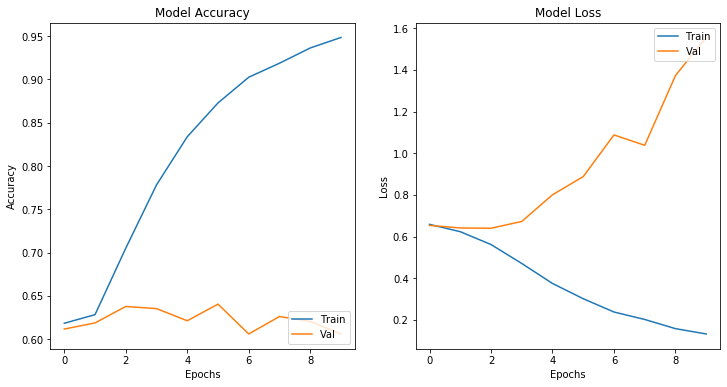

In [85]:
plt.figure(figsize=(12,6))

plt.subplot(121)
plt.plot(history.history["acc"])
plt.plot(history.history["val_acc"])
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Train","Val"], loc="lower right")

plt.subplot(122)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend(['Train', 'Val'], loc='upper right')

plt.show()

In [86]:
'''Due to the sklearn method to plot not working this method had to be implimented 
inorder to properly plot a confusion matrix'''
def plot_confusion_matrix(cm,target_names,title='Confusion matrix',normalize=False):

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    plt.figure(figsize=(8, 6))
    plt.grid(b=False)
    plt.imshow(cm, interpolation='nearest', cmap="Blues")
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()


Plots a confusion matrix to show were the model predicted incorrectly.

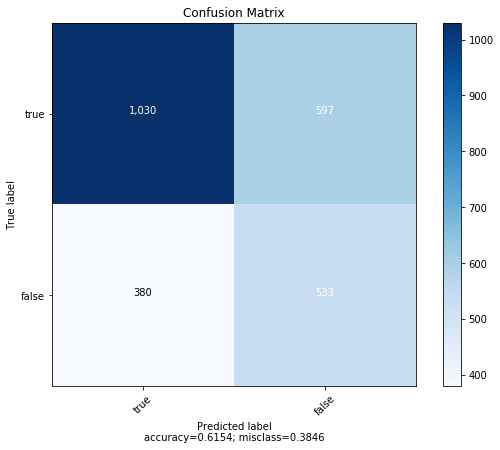

In [87]:
cm = confusion_matrix(test,predict)
plot_confusion_matrix(cm = cm,target_names = ["true","false"],title="Confusion Matrix")

Gets example preictions.

In [88]:
indecies = getRandomIndecies(len(y_predict),n_indecies=10)

Decodes encoded token sequences.

In [89]:
def decode(token_list,token_decode):
    decoded_tokens = list()
    for item in token_list:
        tokens = list()
        for token in item:
            tokens.append(token_decode[token])
        decoded_tokens.append(tokens)
    return decoded_tokens

In [90]:
q_decode = decode(q_x_test,decoder)
p_decode = decode(p_x_test,decoder)

Prints predictions for error analysis.

In [91]:
for index in indecies:
    print(q_decode[index],'\n')
    print(p_decode[index],'\n')
    print(y_test[index], '\n')
    print(y_predict[index], '\n')

['person', 'die', 'from', 'drinking', 'too', 'much', 'water', '%PAD%', '%PAD%', '%PAD%', '%PAD%', '%PAD%', '%PAD%', '%PAD%', '%PAD%'] 

['under', 'normal', 'circumstances', 'accidentally', 'consuming', 'too', 'much', 'water', 'exceptionally', 'rare', 'nearly', 'all', 'deaths', 'related', 'water', 'intoxication', 'normal', 'individuals', 'resulted', 'either', 'from', 'water', 'drinking', 'contests', 'which', 'individuals', 'attempt', 'consume', 'large', 'amounts', 'water', 'or', 'from', 'long', 'bouts', 'exercise', 'during', 'which', 'excessive', 'amounts', 'fluid', 'were', 'consumed', 'addition', 'water', 'cure', 'method', 'torture', 'which', 'victim', 'forced', 'consume', 'excessive', 'amounts', 'water', 'cause', 'water', 'intoxication', '%PAD%', '%PAD%', '%PAD%', '%PAD%', '%PAD%', '%PAD%', '%PAD%', '%PAD%', '%PAD%', '%PAD%', '%PAD%', '%PAD%', '%PAD%', '%PAD%', '%PAD%', '%PAD%', '%PAD%', '%PAD%', '%PAD%', '%PAD%', '%PAD%', '%PAD%', '%PAD%', '%PAD%', '%PAD%', '%PAD%', '%PAD%', '%PAD%',

# 7) Deploy, Monitor, Maintain

## Deploy

Currently, this model is not in a state to be deployed. With better feature engineering or a more relative data set, this model could perform well enough to be deployed through cloud services in order to answer more narrow questions.

## Monitor

In order to monitor our model, we would compare the current dictionaries to the new dictionaires and make changes to improve the accuracy for future questions.

## Maintain

In order to maintain this model, we could update the dictionary to support the majority of words used instead of specifying the dictonary towards our dataset.

# 8) Summary

Our baseline tdifVecotrlizer preformed slightly better than the RNN. The logistic regression baseline had signifigantly less feature engineering and ran much quicker. This could mean a more complex model architecture is needed.The paper that we used as reference delves deeper with the idea that "Exploring the Surprising Difficulty of Natural Yes/No Questions" is a hard topic that is still being worked on. Newer technology allows for attention layers that detect similarities in the question and passage and output a score based on the similarities. With this new technology, we could have improved the validation accuracy based on similar word groupings. Overall, this project has room for improvement in the future with newer versions and more similar datasets. 